# referred paper

synthesizing filamentary structured images with GANs

# mount drive

In [ ]:
import os
from PIL import Image

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive')

# clone git

In [ ]:
!git clone https://github.com/guyuchao/Fila-sGAN-pytorch.git

Cloning into 'Fila-sGAN-pytorch'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 23.30 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Checking out files: 100% (151/151), done.


In [ ]:
os.chdir('/content/drive/MyDrive/Fila-sGAN-pytorch')

# prepare dataset

we here use DRIVE dataset that can be obtained at https://drive.grand-challenge.org/.

This is the example of data:

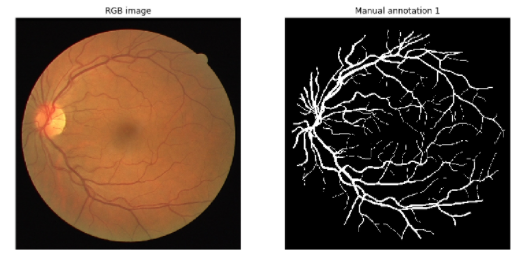


# Fila-GAN

import library

In [ ]:
from __future__ import division
import torch
import pandas as pd
from torch.autograd import Variable
from torch.utils import data
from Vgg import Vgg16
from gycutils.trainschedule import Scheduler
from gycutils.utils import make_trainable,get_tv_loss,get_content_loss,get_content_features,get_style_features,get_style_loss
from gan import Discriminator,Generator
from datasets import VOCDataSet
from torch.optim import Adam
from loss import BCE_Loss
from transform import ReLabel, ToLabel
from torchvision.transforms import Compose, Normalize, ToTensor,Resize
import tqdm
#from Criterion import Criterion
from PIL import Image
import torch.nn.functional as F
import numpy as np
import os
from gycutils.gycaug import Img_to_zero_center,Random_horizontal_flip,Random_vertical_flip,Compose_imglabel,Random_crop

In [ ]:
input_transform = Compose([
    #Resize(512, interpolation=Image.BICUBIC),
    ToTensor(),
    Img_to_zero_center()
    ])
target_transform = Compose([
    #Resize(512, interpolation=Image.BICUBIC),

    ToLabel(),
    ReLabel(255, 1),
    Img_to_zero_center()
    ])
mask_transform = Compose([
    #Resize(512, interpolation=Image.BICUBIC),
    ToLabel(),
    ReLabel(255, 1),
    Img_to_zero_center()
    ])

pth="./eyedata/style/style.tif"
#style_imgs=[]
#for filename in os.listdir(pth):
 #   if len(style_imgs)>5:
  #      break
style_img=Image.open(pth)
style_img=Variable(input_transform(style_img),requires_grad=False).cuda()
trainloader = data.DataLoader(VOCDataSet("./", img_transform=input_transform,
                                         label_transform=target_transform,mask_transform=mask_transform),
                              batch_size=1, shuffle=True, pin_memory=True)

valloader = data.DataLoader(VOCDataSet("./", split='val',img_transform=input_transform,
                                         label_transform=target_transform,mask_transform=mask_transform),
                              batch_size=1, shuffle=True, pin_memory=True)

set parameters

In [ ]:
#Parameters
#adversarial
L_gan_weight=1
#style
L_style_weight=10
#content
L_content_weight=1
#tv
L_tv_weight=100

lr=0.0002
beta1=0.5
batch_size=1
max_epoch=200

channel=3
img_size=564
img_x=564
img_y=564

style_size=564
sample_batch=4
z_size=400

prepare random noise to generate

In [ ]:
def gen_rand_noise(batch_size,z_size,mean=0,std=0.001):
    z_sample = np.random.normal(mean, std, size=[batch_size, z_size]).astype(np.float32)
    z=torch.from_numpy(z_sample)
    return z

prepare discriminant and generator based VGG16

In [ ]:
G=Generator().cuda()
D=Discriminator().cuda()
Vgg=Vgg16().cuda()
bce=BCE_Loss()
mse=torch.nn.MSELoss()
optimizer_d = torch.optim.SGD(D.parameters(), lr=lr*0.4)
optimizer_g = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.9))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

train model

In [ ]:
tabel = pd.DataFrame(columns=['epoch','d_loss','g_loss_adversial','style_loss','content_loss','tv_loss'])
for epoch in range(max_epoch):
    for idx, (real_img, real_label,mask) in tqdm.tqdm(enumerate(trainloader)):
        # trainD
        make_trainable(D, True)
        make_trainable(G, False)

        D.zero_grad()
        optimizer_d.zero_grad()

        real_img = Variable(real_img).cuda()
        real_label = Variable(real_label.unsqueeze(1)).cuda()
        mask=Variable(mask.unsqueeze(1)).cuda()

        z = Variable(gen_rand_noise(batch_size,z_size)).cuda()
        real_label_mask_pair=torch.cat((real_label,mask),dim=1)
        fake_imgs=G(real_label_mask_pair,z)

        real_pair=torch.cat((real_img,real_label,mask),dim=1)
        fake_pair=torch.cat((fake_imgs,real_label,mask),dim=1)

        D_real_logits=D(real_pair)
        D_real_y=Variable(torch.ones((batch_size,1))).cuda()

        D_fake_logits=D(fake_pair)
        D_fake_y=Variable(torch.zeros((batch_size,1))).cuda()

        d_real_loss=bce(D_real_logits,D_real_y)
        d_fake_loss=bce(D_fake_logits,D_fake_y)

        d_loss=d_real_loss+d_fake_loss
        d_loss.backward()
        optimizer_d.step()

        #trainG twice
        make_trainable(G, True)
        make_trainable(D, False)
        make_trainable(Vgg,False)
        for _ in range(1):
            G.zero_grad()
            optimizer_g.zero_grad()

            z = Variable(gen_rand_noise(batch_size, z_size,0,0.5)).cuda()
            real_label_mask_pair = torch.cat((real_label, mask), dim=1)
            fake_imgs = G(real_label_mask_pair, z)
            fake_pair=torch.cat((fake_imgs,real_label,mask),dim=1)

            D_fake_logits=D(fake_pair)
            D_fake_y=Variable(torch.ones((batch_size,1))).cuda()
            #gan_loss
            g_loss_adversial=bce(D_fake_logits,D_fake_y)
            #style loss
            #style_loss=0.0
            #for i,style_img in enumerate(style_imgs):
            style_feature = get_style_features(Vgg, style_img,mask)
            style_loss=get_style_loss(style_feature,get_style_features(Vgg,fake_imgs,mask))#/len(style_imgs)
            #content_loss
            content_loss=get_content_loss(get_content_features(Vgg,real_img,mask),get_content_features(Vgg,fake_imgs,mask))
            #tv_loss
            tv_loss=get_tv_loss(fake_imgs)
            loss=L_gan_weight*g_loss_adversial+L_style_weight*style_loss+L_content_weight*content_loss+L_tv_weight*tv_loss
            loss.backward()
            optimizer_g.step()

    print("epoch[%d/%d] d_loss:%.4f g_loss_ad:%.4f style_loss:%.4f content_loss:%.4f tv_loss%.4f"%(
        epoch,max_epoch,d_loss,g_loss_adversial,style_loss,content_loss,tv_loss
    ))
    tabel.loc[epoch] = [int(epoch), round(float(d_loss), 4), round(float(g_loss_adversial), 4),
                        round(float(style_loss), 4), round(float(content_loss), 4), round(float(tv_loss), 4)]
    tabel.to_csv('tabel.csv', index = False)

    if epoch%50==0:
        G.eval()
        D.eval()

        os.mkdir('./pth/epoch%d'%epoch)
        for idx, (real_img, real_label, mask) in tqdm.tqdm(enumerate(valloader)):
            os.mkdir('./pth/epoch%d/label%d' %(epoch,idx) )
            real_img = Variable(real_img).cuda()
            real_label = Variable(real_label.unsqueeze(1)).cuda()
            img_label=real_label.squeeze(1).cpu().data[0].numpy()
            #print(img_label.shape)
            Image.fromarray(img_label.astype(np.uint8)).save('./pth/epoch%d/label%d/label.jpg'%(epoch,idx))
            mask = Variable(mask.unsqueeze(1)).cuda()

            for i in range(5):
                z=Variable(gen_rand_noise(1,z_size,0,0.5)).cuda()
                real_label_mask_pair = torch.cat((real_label, mask), dim=1)
                fake_imgs = G(real_label_mask_pair, z)[0].cpu().data.numpy()
                img=np.transpose(fake_imgs,[1,2,0])

                img=(img+1)*127.5
                img=Image.fromarray(img.astype(np.uint8))
                img.save('./pth/epoch%d/label%d/%d.jpg'%(epoch,idx,i))


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
20it [00:21,  1.06s/it]


epoch[0/2000] d_loss:0.4773 g_loss_ad:1.7802 style_loss:7.7631 content_loss:26.4299 tv_loss0.1485


12it [00:05,  2.34it/s]
20it [00:21,  1.05s/it]


epoch[1/2000] d_loss:0.0975 g_loss_ad:3.1777 style_loss:7.0014 content_loss:30.5785 tv_loss0.0767


20it [00:21,  1.05s/it]


epoch[2/2000] d_loss:0.0733 g_loss_ad:3.0731 style_loss:2.8453 content_loss:25.0864 tv_loss0.0718


20it [00:20,  1.05s/it]


epoch[3/2000] d_loss:0.8583 g_loss_ad:0.4648 style_loss:3.5076 content_loss:31.5839 tv_loss0.0726


20it [00:20,  1.05s/it]


epoch[4/2000] d_loss:0.7983 g_loss_ad:0.8518 style_loss:1.5117 content_loss:24.7447 tv_loss0.0531


20it [00:20,  1.04s/it]


epoch[5/2000] d_loss:0.3434 g_loss_ad:1.8810 style_loss:1.3102 content_loss:26.6993 tv_loss0.0498


20it [00:20,  1.04s/it]


epoch[6/2000] d_loss:0.2933 g_loss_ad:1.9088 style_loss:2.3297 content_loss:24.2521 tv_loss0.0488


20it [00:20,  1.04s/it]


epoch[7/2000] d_loss:0.1086 g_loss_ad:2.8493 style_loss:2.3754 content_loss:28.5352 tv_loss0.0456


20it [00:20,  1.04s/it]


epoch[8/2000] d_loss:0.0809 g_loss_ad:3.2342 style_loss:3.2309 content_loss:25.0783 tv_loss0.0438


20it [00:20,  1.04s/it]


epoch[9/2000] d_loss:0.0467 g_loss_ad:3.9842 style_loss:1.5795 content_loss:24.1107 tv_loss0.0401


20it [00:20,  1.04s/it]


epoch[10/2000] d_loss:0.0302 g_loss_ad:4.0478 style_loss:2.4214 content_loss:24.8656 tv_loss0.0409


20it [00:20,  1.04s/it]


epoch[11/2000] d_loss:0.0296 g_loss_ad:3.8945 style_loss:1.2393 content_loss:24.0764 tv_loss0.0374


20it [00:20,  1.04s/it]


epoch[12/2000] d_loss:0.0184 g_loss_ad:4.5856 style_loss:2.3591 content_loss:27.6344 tv_loss0.0419


20it [00:20,  1.04s/it]


epoch[13/2000] d_loss:0.0315 g_loss_ad:4.4404 style_loss:1.2210 content_loss:21.9800 tv_loss0.0366


20it [00:20,  1.04s/it]


epoch[14/2000] d_loss:0.0214 g_loss_ad:4.2913 style_loss:1.2758 content_loss:22.4851 tv_loss0.0374


20it [00:20,  1.04s/it]


epoch[15/2000] d_loss:0.0427 g_loss_ad:3.9310 style_loss:1.2741 content_loss:28.6632 tv_loss0.0384


20it [00:20,  1.04s/it]


epoch[16/2000] d_loss:0.1147 g_loss_ad:3.6549 style_loss:1.2503 content_loss:23.3514 tv_loss0.0401


20it [00:20,  1.04s/it]


epoch[17/2000] d_loss:8.0314 g_loss_ad:4.0468 style_loss:4.3328 content_loss:28.9571 tv_loss0.0437


20it [00:20,  1.05s/it]


epoch[18/2000] d_loss:0.0308 g_loss_ad:3.8307 style_loss:1.0729 content_loss:22.6944 tv_loss0.0389


20it [00:20,  1.05s/it]


epoch[19/2000] d_loss:0.0683 g_loss_ad:3.7914 style_loss:0.9884 content_loss:23.5418 tv_loss0.0395


20it [00:20,  1.05s/it]


epoch[20/2000] d_loss:0.0872 g_loss_ad:4.0462 style_loss:1.1371 content_loss:23.7256 tv_loss0.0406


20it [00:20,  1.04s/it]


epoch[21/2000] d_loss:0.0113 g_loss_ad:4.6459 style_loss:1.3839 content_loss:25.0132 tv_loss0.0380


20it [00:20,  1.04s/it]


epoch[22/2000] d_loss:0.0717 g_loss_ad:3.3686 style_loss:1.3098 content_loss:26.0601 tv_loss0.0417


20it [00:20,  1.04s/it]


epoch[23/2000] d_loss:0.0435 g_loss_ad:3.8870 style_loss:1.0368 content_loss:26.5511 tv_loss0.0412


20it [00:20,  1.04s/it]


epoch[24/2000] d_loss:0.1712 g_loss_ad:3.9407 style_loss:1.1326 content_loss:26.3500 tv_loss0.0423


20it [00:20,  1.04s/it]


epoch[25/2000] d_loss:0.1110 g_loss_ad:3.5154 style_loss:2.4289 content_loss:27.5807 tv_loss0.0455


20it [00:20,  1.04s/it]


epoch[26/2000] d_loss:0.0094 g_loss_ad:4.7849 style_loss:1.0580 content_loss:28.8602 tv_loss0.0397


20it [00:20,  1.04s/it]


epoch[27/2000] d_loss:0.0205 g_loss_ad:4.1067 style_loss:0.9886 content_loss:24.7628 tv_loss0.0428


20it [00:20,  1.04s/it]


epoch[28/2000] d_loss:0.0211 g_loss_ad:4.3885 style_loss:1.1454 content_loss:23.9170 tv_loss0.0401


20it [00:20,  1.04s/it]


epoch[29/2000] d_loss:0.0253 g_loss_ad:4.0189 style_loss:1.9348 content_loss:25.7140 tv_loss0.0439


20it [00:20,  1.04s/it]


epoch[30/2000] d_loss:0.0813 g_loss_ad:3.1266 style_loss:1.0351 content_loss:22.7112 tv_loss0.0407


20it [00:20,  1.04s/it]


epoch[31/2000] d_loss:0.0776 g_loss_ad:3.7424 style_loss:0.8648 content_loss:24.6532 tv_loss0.0381


20it [00:20,  1.04s/it]


epoch[32/2000] d_loss:100.0000 g_loss_ad:0.0000 style_loss:1.1858 content_loss:22.2973 tv_loss0.0379


20it [00:20,  1.04s/it]


epoch[33/2000] d_loss:100.0000 g_loss_ad:0.0000 style_loss:1.7855 content_loss:22.9017 tv_loss0.0399


20it [00:20,  1.04s/it]


epoch[34/2000] d_loss:0.2919 g_loss_ad:2.4839 style_loss:0.7799 content_loss:22.2238 tv_loss0.0380


20it [00:20,  1.04s/it]


epoch[35/2000] d_loss:0.2819 g_loss_ad:2.4329 style_loss:1.0731 content_loss:22.1337 tv_loss0.0385


20it [00:20,  1.04s/it]


epoch[36/2000] d_loss:0.0405 g_loss_ad:3.6489 style_loss:1.0316 content_loss:23.3249 tv_loss0.0402


20it [00:20,  1.04s/it]


epoch[37/2000] d_loss:0.0152 g_loss_ad:4.4193 style_loss:0.9813 content_loss:22.6804 tv_loss0.0402


20it [00:20,  1.04s/it]


epoch[38/2000] d_loss:0.0173 g_loss_ad:4.1512 style_loss:0.7758 content_loss:23.9767 tv_loss0.0378


20it [00:20,  1.04s/it]


epoch[39/2000] d_loss:0.0237 g_loss_ad:3.9811 style_loss:1.2329 content_loss:23.6381 tv_loss0.0397


20it [00:20,  1.04s/it]


epoch[40/2000] d_loss:0.0238 g_loss_ad:3.9925 style_loss:0.9114 content_loss:30.1980 tv_loss0.0384


20it [00:20,  1.04s/it]


epoch[41/2000] d_loss:0.0561 g_loss_ad:4.2079 style_loss:0.8851 content_loss:22.0141 tv_loss0.0382


20it [00:20,  1.04s/it]


epoch[42/2000] d_loss:0.0168 g_loss_ad:4.4697 style_loss:0.8995 content_loss:25.7627 tv_loss0.0372


20it [00:20,  1.04s/it]


epoch[43/2000] d_loss:0.0039 g_loss_ad:5.3836 style_loss:0.8127 content_loss:23.8457 tv_loss0.0383


20it [00:20,  1.04s/it]


epoch[44/2000] d_loss:0.0242 g_loss_ad:3.7744 style_loss:1.5335 content_loss:23.7277 tv_loss0.0408


20it [00:20,  1.04s/it]


epoch[45/2000] d_loss:0.0676 g_loss_ad:2.5178 style_loss:2.1286 content_loss:23.6572 tv_loss0.0401


20it [00:20,  1.04s/it]


epoch[46/2000] d_loss:0.1504 g_loss_ad:1.5435 style_loss:1.4373 content_loss:26.2511 tv_loss0.0408


20it [00:20,  1.04s/it]


epoch[47/2000] d_loss:0.0714 g_loss_ad:4.0165 style_loss:0.7431 content_loss:22.5539 tv_loss0.0399


20it [00:20,  1.04s/it]


epoch[48/2000] d_loss:0.0136 g_loss_ad:3.5904 style_loss:1.0749 content_loss:22.9851 tv_loss0.0414


20it [00:20,  1.04s/it]


epoch[49/2000] d_loss:0.0528 g_loss_ad:2.8061 style_loss:0.7673 content_loss:23.1718 tv_loss0.0395


20it [00:20,  1.04s/it]


epoch[50/2000] d_loss:0.3550 g_loss_ad:2.9618 style_loss:0.6371 content_loss:22.3806 tv_loss0.0398


12it [00:05,  2.30it/s]
20it [00:20,  1.04s/it]


epoch[51/2000] d_loss:0.0208 g_loss_ad:3.7455 style_loss:1.1889 content_loss:25.1633 tv_loss0.0387


20it [00:20,  1.04s/it]


epoch[52/2000] d_loss:0.0117 g_loss_ad:3.7944 style_loss:0.6761 content_loss:25.7866 tv_loss0.0395


20it [00:20,  1.04s/it]


epoch[53/2000] d_loss:0.3216 g_loss_ad:0.6452 style_loss:2.0866 content_loss:23.8352 tv_loss0.0417


20it [00:20,  1.04s/it]


epoch[54/2000] d_loss:1.0296 g_loss_ad:6.4265 style_loss:0.6401 content_loss:25.0794 tv_loss0.0384


20it [00:20,  1.04s/it]


epoch[55/2000] d_loss:0.0259 g_loss_ad:4.7688 style_loss:0.8002 content_loss:25.2356 tv_loss0.0383


20it [00:20,  1.04s/it]


epoch[56/2000] d_loss:0.0456 g_loss_ad:2.8293 style_loss:0.7992 content_loss:23.0023 tv_loss0.0383


20it [00:20,  1.04s/it]


epoch[57/2000] d_loss:0.0628 g_loss_ad:2.6284 style_loss:0.8863 content_loss:26.1098 tv_loss0.0409


20it [00:20,  1.04s/it]


epoch[58/2000] d_loss:3.6058 g_loss_ad:4.1909 style_loss:1.0745 content_loss:26.2569 tv_loss0.0391


20it [00:20,  1.04s/it]


epoch[59/2000] d_loss:0.0359 g_loss_ad:2.3229 style_loss:1.4347 content_loss:24.5087 tv_loss0.0394


20it [00:20,  1.04s/it]


epoch[60/2000] d_loss:0.2326 g_loss_ad:0.7126 style_loss:0.7433 content_loss:22.6686 tv_loss0.0404


20it [00:20,  1.04s/it]


epoch[61/2000] d_loss:0.0304 g_loss_ad:2.2427 style_loss:0.9324 content_loss:24.8562 tv_loss0.0375


20it [00:20,  1.04s/it]


epoch[62/2000] d_loss:0.3029 g_loss_ad:0.5398 style_loss:0.7751 content_loss:26.0693 tv_loss0.0396


20it [00:20,  1.04s/it]


epoch[63/2000] d_loss:0.1985 g_loss_ad:0.8924 style_loss:0.7015 content_loss:22.6797 tv_loss0.0404


20it [00:20,  1.04s/it]


epoch[64/2000] d_loss:0.2503 g_loss_ad:2.6586 style_loss:1.0202 content_loss:24.2097 tv_loss0.0383


20it [00:20,  1.04s/it]


epoch[65/2000] d_loss:0.0015 g_loss_ad:5.2889 style_loss:0.9207 content_loss:25.5838 tv_loss0.0415


20it [00:20,  1.04s/it]


epoch[66/2000] d_loss:0.6448 g_loss_ad:0.3730 style_loss:1.1123 content_loss:23.7999 tv_loss0.0422


20it [00:20,  1.04s/it]


epoch[67/2000] d_loss:2.8887 g_loss_ad:5.9477 style_loss:0.7193 content_loss:23.4384 tv_loss0.0381


20it [00:20,  1.04s/it]


epoch[68/2000] d_loss:0.4018 g_loss_ad:2.6822 style_loss:1.1937 content_loss:26.4868 tv_loss0.0401


20it [00:20,  1.04s/it]


epoch[69/2000] d_loss:0.0349 g_loss_ad:2.6859 style_loss:0.8143 content_loss:24.1873 tv_loss0.0378


20it [00:20,  1.04s/it]


epoch[70/2000] d_loss:0.0767 g_loss_ad:1.7923 style_loss:1.0399 content_loss:23.1433 tv_loss0.0383


20it [00:20,  1.04s/it]


epoch[71/2000] d_loss:0.3648 g_loss_ad:0.4566 style_loss:0.9621 content_loss:23.8910 tv_loss0.0380


20it [00:20,  1.04s/it]


epoch[72/2000] d_loss:0.0251 g_loss_ad:2.5223 style_loss:1.0087 content_loss:22.8301 tv_loss0.0373


20it [00:20,  1.04s/it]


epoch[73/2000] d_loss:0.0098 g_loss_ad:5.1029 style_loss:0.6494 content_loss:25.8120 tv_loss0.0374


20it [00:20,  1.04s/it]


epoch[74/2000] d_loss:0.2710 g_loss_ad:3.0026 style_loss:0.8660 content_loss:23.8954 tv_loss0.0369


20it [00:20,  1.04s/it]


epoch[75/2000] d_loss:0.0306 g_loss_ad:3.0283 style_loss:1.2259 content_loss:23.7117 tv_loss0.0392


20it [00:20,  1.04s/it]


epoch[76/2000] d_loss:0.0804 g_loss_ad:1.6720 style_loss:1.8289 content_loss:26.6591 tv_loss0.0400


20it [00:20,  1.04s/it]


epoch[77/2000] d_loss:0.0175 g_loss_ad:2.5475 style_loss:1.2248 content_loss:23.5136 tv_loss0.0385


20it [00:20,  1.04s/it]


epoch[78/2000] d_loss:0.0172 g_loss_ad:2.9560 style_loss:0.5785 content_loss:25.9032 tv_loss0.0384


20it [00:20,  1.04s/it]


epoch[79/2000] d_loss:0.1250 g_loss_ad:1.4491 style_loss:0.4663 content_loss:22.4389 tv_loss0.0388


20it [00:20,  1.04s/it]


epoch[80/2000] d_loss:2.7273 g_loss_ad:0.0001 style_loss:1.0506 content_loss:23.1085 tv_loss0.0375


20it [00:20,  1.04s/it]


epoch[81/2000] d_loss:0.0259 g_loss_ad:3.4015 style_loss:0.6345 content_loss:25.9126 tv_loss0.0370


20it [00:20,  1.04s/it]


epoch[82/2000] d_loss:0.0082 g_loss_ad:3.0719 style_loss:1.4655 content_loss:25.4405 tv_loss0.0393


20it [00:20,  1.04s/it]


epoch[83/2000] d_loss:0.0614 g_loss_ad:1.6432 style_loss:0.7096 content_loss:25.2429 tv_loss0.0382


20it [00:20,  1.04s/it]


epoch[84/2000] d_loss:0.0498 g_loss_ad:2.0494 style_loss:0.7538 content_loss:23.1347 tv_loss0.0392


20it [00:20,  1.04s/it]


epoch[85/2000] d_loss:0.3731 g_loss_ad:3.0547 style_loss:0.8536 content_loss:24.5863 tv_loss0.0363


20it [00:20,  1.04s/it]


epoch[86/2000] d_loss:0.0080 g_loss_ad:3.8920 style_loss:0.5982 content_loss:25.5001 tv_loss0.0373


20it [00:20,  1.04s/it]


epoch[87/2000] d_loss:0.0434 g_loss_ad:7.3936 style_loss:0.6245 content_loss:25.5565 tv_loss0.0354


20it [00:20,  1.04s/it]


epoch[88/2000] d_loss:0.0091 g_loss_ad:3.2621 style_loss:0.7267 content_loss:25.5902 tv_loss0.0382


20it [00:20,  1.04s/it]


epoch[89/2000] d_loss:0.1583 g_loss_ad:1.7545 style_loss:0.5067 content_loss:23.6748 tv_loss0.0381


20it [00:20,  1.04s/it]


epoch[90/2000] d_loss:0.0593 g_loss_ad:4.9771 style_loss:0.7881 content_loss:25.6730 tv_loss0.0358


20it [00:20,  1.04s/it]


epoch[91/2000] d_loss:0.0252 g_loss_ad:2.8124 style_loss:1.9211 content_loss:25.6570 tv_loss0.0394


20it [00:20,  1.04s/it]


epoch[92/2000] d_loss:0.0680 g_loss_ad:3.2091 style_loss:0.7615 content_loss:24.4990 tv_loss0.0381


20it [00:20,  1.04s/it]


epoch[93/2000] d_loss:0.1909 g_loss_ad:3.3306 style_loss:0.9522 content_loss:22.1920 tv_loss0.0383


20it [00:20,  1.04s/it]


epoch[94/2000] d_loss:0.1248 g_loss_ad:2.7479 style_loss:0.6399 content_loss:22.0058 tv_loss0.0372


20it [00:20,  1.04s/it]


epoch[95/2000] d_loss:0.0201 g_loss_ad:3.8756 style_loss:0.7891 content_loss:25.7850 tv_loss0.0386


20it [00:20,  1.04s/it]


epoch[96/2000] d_loss:0.0133 g_loss_ad:4.4095 style_loss:0.9026 content_loss:22.4913 tv_loss0.0372


20it [00:20,  1.04s/it]


epoch[97/2000] d_loss:0.0225 g_loss_ad:10.8437 style_loss:1.1616 content_loss:29.6687 tv_loss0.0373


20it [00:20,  1.04s/it]


epoch[98/2000] d_loss:0.0298 g_loss_ad:4.3457 style_loss:0.8264 content_loss:22.7419 tv_loss0.0387


20it [00:20,  1.04s/it]


epoch[99/2000] d_loss:0.0590 g_loss_ad:2.7461 style_loss:0.8779 content_loss:23.9873 tv_loss0.0386


20it [00:20,  1.04s/it]


epoch[100/2000] d_loss:0.0349 g_loss_ad:3.3230 style_loss:0.5615 content_loss:24.9035 tv_loss0.0385


12it [00:05,  2.33it/s]
20it [00:20,  1.04s/it]


epoch[101/2000] d_loss:0.0369 g_loss_ad:3.0468 style_loss:0.6171 content_loss:22.3864 tv_loss0.0373


20it [00:21,  1.05s/it]


epoch[102/2000] d_loss:0.6621 g_loss_ad:8.7750 style_loss:2.5173 content_loss:24.8361 tv_loss0.0402


20it [00:21,  1.06s/it]


epoch[103/2000] d_loss:0.0392 g_loss_ad:4.3180 style_loss:0.8790 content_loss:25.0474 tv_loss0.0370


20it [00:21,  1.06s/it]


epoch[104/2000] d_loss:0.1190 g_loss_ad:3.7814 style_loss:0.7800 content_loss:23.4820 tv_loss0.0381


20it [00:21,  1.06s/it]


epoch[105/2000] d_loss:0.1530 g_loss_ad:1.8925 style_loss:1.6591 content_loss:22.5371 tv_loss0.0396


20it [00:21,  1.05s/it]


epoch[106/2000] d_loss:0.0235 g_loss_ad:5.2885 style_loss:0.8999 content_loss:24.9891 tv_loss0.0381


20it [00:20,  1.05s/it]


epoch[107/2000] d_loss:0.0687 g_loss_ad:2.5851 style_loss:0.9756 content_loss:22.2862 tv_loss0.0383


20it [00:20,  1.05s/it]


epoch[108/2000] d_loss:0.0057 g_loss_ad:6.2714 style_loss:0.6016 content_loss:25.6767 tv_loss0.0392


20it [00:20,  1.05s/it]


epoch[109/2000] d_loss:0.3947 g_loss_ad:0.1535 style_loss:0.5293 content_loss:25.7826 tv_loss0.0391


20it [00:20,  1.05s/it]


epoch[110/2000] d_loss:0.0267 g_loss_ad:3.2685 style_loss:0.6018 content_loss:26.3097 tv_loss0.0384


20it [00:20,  1.05s/it]


epoch[111/2000] d_loss:0.4770 g_loss_ad:0.5459 style_loss:1.0606 content_loss:22.6338 tv_loss0.0399


20it [00:21,  1.05s/it]


epoch[112/2000] d_loss:0.1987 g_loss_ad:1.6941 style_loss:0.5385 content_loss:22.3541 tv_loss0.0385


20it [00:20,  1.05s/it]


epoch[113/2000] d_loss:0.0086 g_loss_ad:4.0306 style_loss:0.9585 content_loss:25.7037 tv_loss0.0396


20it [00:20,  1.05s/it]


epoch[114/2000] d_loss:1.2736 g_loss_ad:0.0000 style_loss:0.7314 content_loss:24.2905 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[115/2000] d_loss:0.4057 g_loss_ad:3.6821 style_loss:0.7478 content_loss:21.9903 tv_loss0.0377


20it [00:20,  1.05s/it]


epoch[116/2000] d_loss:0.0184 g_loss_ad:3.4461 style_loss:0.6215 content_loss:30.7577 tv_loss0.0370


20it [00:21,  1.05s/it]


epoch[117/2000] d_loss:0.0104 g_loss_ad:4.1769 style_loss:1.8937 content_loss:32.3943 tv_loss0.0389


20it [00:20,  1.05s/it]


epoch[118/2000] d_loss:0.2873 g_loss_ad:3.0464 style_loss:0.8100 content_loss:23.6391 tv_loss0.0379


20it [00:21,  1.05s/it]


epoch[119/2000] d_loss:0.0235 g_loss_ad:3.0256 style_loss:0.5993 content_loss:22.9553 tv_loss0.0373


20it [00:20,  1.05s/it]


epoch[120/2000] d_loss:0.0089 g_loss_ad:4.7339 style_loss:0.5957 content_loss:22.6219 tv_loss0.0378


20it [00:20,  1.05s/it]


epoch[121/2000] d_loss:0.1959 g_loss_ad:3.2922 style_loss:0.8285 content_loss:23.1829 tv_loss0.0369


20it [00:20,  1.05s/it]


epoch[122/2000] d_loss:0.0396 g_loss_ad:3.0791 style_loss:0.8600 content_loss:30.7645 tv_loss0.0366


20it [00:20,  1.05s/it]


epoch[123/2000] d_loss:0.0193 g_loss_ad:3.4432 style_loss:1.0378 content_loss:30.9186 tv_loss0.0377


20it [00:21,  1.05s/it]


epoch[124/2000] d_loss:0.0103 g_loss_ad:3.6672 style_loss:0.7538 content_loss:30.8274 tv_loss0.0370


20it [00:20,  1.05s/it]


epoch[125/2000] d_loss:0.0913 g_loss_ad:2.7906 style_loss:0.6591 content_loss:22.0452 tv_loss0.0369


20it [00:20,  1.05s/it]


epoch[126/2000] d_loss:2.4917 g_loss_ad:12.1885 style_loss:1.2239 content_loss:24.7664 tv_loss0.0372


20it [00:20,  1.05s/it]


epoch[127/2000] d_loss:0.0104 g_loss_ad:7.1173 style_loss:0.6762 content_loss:26.1867 tv_loss0.0367


20it [00:20,  1.05s/it]


epoch[128/2000] d_loss:0.0708 g_loss_ad:3.4740 style_loss:1.2672 content_loss:26.6829 tv_loss0.0365


20it [00:20,  1.05s/it]


epoch[129/2000] d_loss:0.0292 g_loss_ad:3.2085 style_loss:0.8141 content_loss:23.7723 tv_loss0.0375


20it [00:20,  1.05s/it]


epoch[130/2000] d_loss:0.4771 g_loss_ad:1.5846 style_loss:0.7297 content_loss:24.5351 tv_loss0.0366


20it [00:20,  1.05s/it]


epoch[131/2000] d_loss:0.0784 g_loss_ad:4.0607 style_loss:1.3117 content_loss:23.3218 tv_loss0.0364


20it [00:20,  1.05s/it]


epoch[132/2000] d_loss:0.0423 g_loss_ad:3.6634 style_loss:1.6077 content_loss:25.9933 tv_loss0.0384


20it [00:21,  1.05s/it]


epoch[133/2000] d_loss:0.0012 g_loss_ad:8.4102 style_loss:0.5665 content_loss:26.5497 tv_loss0.0377


20it [00:20,  1.05s/it]


epoch[134/2000] d_loss:0.1392 g_loss_ad:4.2165 style_loss:1.0430 content_loss:24.8505 tv_loss0.0381


20it [00:20,  1.05s/it]


epoch[135/2000] d_loss:0.0008 g_loss_ad:7.3919 style_loss:0.9485 content_loss:26.0883 tv_loss0.0373


20it [00:20,  1.05s/it]


epoch[136/2000] d_loss:0.0325 g_loss_ad:3.8177 style_loss:0.6669 content_loss:21.8856 tv_loss0.0363


20it [00:20,  1.05s/it]


epoch[137/2000] d_loss:0.9393 g_loss_ad:1.5872 style_loss:0.6943 content_loss:24.3895 tv_loss0.0368


20it [00:20,  1.05s/it]


epoch[138/2000] d_loss:0.0667 g_loss_ad:2.5074 style_loss:0.9379 content_loss:24.1899 tv_loss0.0373


20it [00:21,  1.05s/it]


epoch[139/2000] d_loss:0.6913 g_loss_ad:2.3641 style_loss:0.7329 content_loss:23.6320 tv_loss0.0369


20it [00:20,  1.05s/it]


epoch[140/2000] d_loss:0.1882 g_loss_ad:3.8262 style_loss:0.5139 content_loss:24.7065 tv_loss0.0376


20it [00:20,  1.05s/it]


epoch[141/2000] d_loss:0.0132 g_loss_ad:4.3622 style_loss:0.5856 content_loss:23.4060 tv_loss0.0382


20it [00:20,  1.05s/it]


epoch[142/2000] d_loss:0.0266 g_loss_ad:4.0941 style_loss:0.7476 content_loss:24.6455 tv_loss0.0363


20it [00:20,  1.05s/it]


epoch[143/2000] d_loss:0.0144 g_loss_ad:3.8676 style_loss:0.8974 content_loss:22.8275 tv_loss0.0360


20it [00:20,  1.05s/it]


epoch[144/2000] d_loss:0.0456 g_loss_ad:3.1192 style_loss:0.7547 content_loss:21.7663 tv_loss0.0356


20it [00:20,  1.05s/it]


epoch[145/2000] d_loss:0.6137 g_loss_ad:0.0711 style_loss:0.9167 content_loss:22.6497 tv_loss0.0383


20it [00:21,  1.05s/it]


epoch[146/2000] d_loss:0.0140 g_loss_ad:3.8580 style_loss:1.4922 content_loss:23.0300 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[147/2000] d_loss:0.0258 g_loss_ad:7.2298 style_loss:0.6374 content_loss:25.7126 tv_loss0.0378


20it [00:20,  1.05s/it]


epoch[148/2000] d_loss:0.0132 g_loss_ad:4.3538 style_loss:0.7844 content_loss:23.9768 tv_loss0.0366


20it [00:20,  1.05s/it]


epoch[149/2000] d_loss:0.2503 g_loss_ad:3.3845 style_loss:1.9784 content_loss:22.1174 tv_loss0.0375


20it [00:20,  1.05s/it]


epoch[150/2000] d_loss:0.0267 g_loss_ad:4.5612 style_loss:0.6375 content_loss:24.0244 tv_loss0.0353


12it [00:05,  2.32it/s]
20it [00:20,  1.05s/it]


epoch[151/2000] d_loss:0.0253 g_loss_ad:4.0899 style_loss:1.1400 content_loss:24.8927 tv_loss0.0370


20it [00:20,  1.05s/it]


epoch[152/2000] d_loss:0.0135 g_loss_ad:4.1825 style_loss:1.0037 content_loss:23.3961 tv_loss0.0359


20it [00:20,  1.05s/it]


epoch[153/2000] d_loss:0.0079 g_loss_ad:4.4105 style_loss:0.6518 content_loss:25.0554 tv_loss0.0366


20it [00:20,  1.05s/it]


epoch[154/2000] d_loss:0.0475 g_loss_ad:3.3130 style_loss:1.2902 content_loss:22.9639 tv_loss0.0363


20it [00:20,  1.05s/it]


epoch[155/2000] d_loss:0.0603 g_loss_ad:2.8307 style_loss:0.7923 content_loss:22.4866 tv_loss0.0354


20it [00:20,  1.05s/it]


epoch[156/2000] d_loss:0.0037 g_loss_ad:5.4976 style_loss:0.7352 content_loss:24.6763 tv_loss0.0360


20it [00:20,  1.05s/it]


epoch[157/2000] d_loss:0.0093 g_loss_ad:4.1121 style_loss:0.7613 content_loss:30.3265 tv_loss0.0475


20it [00:20,  1.05s/it]


epoch[158/2000] d_loss:0.0107 g_loss_ad:4.2868 style_loss:1.0493 content_loss:30.8846 tv_loss0.0448


20it [00:20,  1.05s/it]


epoch[159/2000] d_loss:1.1193 g_loss_ad:6.3962 style_loss:0.4886 content_loss:25.5550 tv_loss0.0451


20it [00:20,  1.05s/it]


epoch[160/2000] d_loss:0.2503 g_loss_ad:1.5991 style_loss:0.6559 content_loss:21.6531 tv_loss0.0471


20it [00:20,  1.05s/it]


epoch[161/2000] d_loss:0.4934 g_loss_ad:0.5545 style_loss:0.8107 content_loss:21.9240 tv_loss0.0482


20it [00:20,  1.05s/it]


epoch[162/2000] d_loss:0.0110 g_loss_ad:6.0458 style_loss:0.5840 content_loss:23.4219 tv_loss0.0454


20it [00:20,  1.05s/it]


epoch[163/2000] d_loss:0.0120 g_loss_ad:7.0561 style_loss:0.9184 content_loss:26.2838 tv_loss0.0403


20it [00:20,  1.05s/it]


epoch[164/2000] d_loss:0.7060 g_loss_ad:6.4809 style_loss:0.9509 content_loss:21.7774 tv_loss0.0473


20it [00:20,  1.05s/it]


epoch[165/2000] d_loss:0.0114 g_loss_ad:4.1840 style_loss:0.5864 content_loss:25.2935 tv_loss0.0404


20it [00:21,  1.05s/it]


epoch[166/2000] d_loss:0.0072 g_loss_ad:5.4090 style_loss:0.7075 content_loss:25.6578 tv_loss0.0469


20it [00:20,  1.05s/it]


epoch[167/2000] d_loss:0.1392 g_loss_ad:2.6640 style_loss:0.6070 content_loss:22.0646 tv_loss0.0474


20it [00:20,  1.05s/it]


epoch[168/2000] d_loss:0.0311 g_loss_ad:3.3422 style_loss:0.9785 content_loss:24.0733 tv_loss0.0465


20it [00:21,  1.05s/it]


epoch[169/2000] d_loss:0.0295 g_loss_ad:3.7101 style_loss:0.6241 content_loss:21.9227 tv_loss0.0432


20it [00:20,  1.05s/it]


epoch[170/2000] d_loss:0.0139 g_loss_ad:4.0820 style_loss:0.7430 content_loss:24.8921 tv_loss0.0466


20it [00:20,  1.05s/it]


epoch[171/2000] d_loss:0.0011 g_loss_ad:6.6632 style_loss:0.7274 content_loss:25.5866 tv_loss0.0412


20it [00:20,  1.05s/it]


epoch[172/2000] d_loss:0.0662 g_loss_ad:3.6762 style_loss:0.7989 content_loss:22.8873 tv_loss0.0450


20it [00:20,  1.05s/it]


epoch[173/2000] d_loss:0.0070 g_loss_ad:7.2195 style_loss:0.7351 content_loss:24.0321 tv_loss0.0442


20it [00:21,  1.05s/it]


epoch[174/2000] d_loss:0.0082 g_loss_ad:8.2668 style_loss:0.7346 content_loss:25.4527 tv_loss0.0459


20it [00:21,  1.05s/it]


epoch[175/2000] d_loss:0.2205 g_loss_ad:4.1836 style_loss:1.5070 content_loss:21.8563 tv_loss0.0429


20it [00:20,  1.05s/it]


epoch[176/2000] d_loss:5.1609 g_loss_ad:6.8742 style_loss:0.6802 content_loss:23.2675 tv_loss0.0405


20it [00:20,  1.05s/it]


epoch[177/2000] d_loss:0.0152 g_loss_ad:5.0368 style_loss:0.7717 content_loss:25.7576 tv_loss0.0465


20it [00:20,  1.05s/it]


epoch[178/2000] d_loss:2.1087 g_loss_ad:8.7692 style_loss:1.0787 content_loss:21.2918 tv_loss0.0410


20it [00:20,  1.05s/it]


epoch[179/2000] d_loss:0.0178 g_loss_ad:4.5613 style_loss:1.2351 content_loss:24.5664 tv_loss0.0434


20it [00:20,  1.05s/it]


epoch[180/2000] d_loss:0.0344 g_loss_ad:4.3444 style_loss:1.2316 content_loss:23.7377 tv_loss0.0457


20it [00:20,  1.05s/it]


epoch[181/2000] d_loss:0.7679 g_loss_ad:0.5841 style_loss:1.4802 content_loss:26.2652 tv_loss0.0443


20it [00:20,  1.05s/it]


epoch[182/2000] d_loss:0.0689 g_loss_ad:4.0258 style_loss:0.7866 content_loss:26.2965 tv_loss0.0426


20it [00:20,  1.05s/it]


epoch[183/2000] d_loss:0.7603 g_loss_ad:0.0066 style_loss:0.9011 content_loss:20.8434 tv_loss0.0404


20it [00:20,  1.05s/it]


epoch[184/2000] d_loss:0.0056 g_loss_ad:5.1497 style_loss:0.6626 content_loss:25.2389 tv_loss0.0387


20it [00:20,  1.05s/it]


epoch[185/2000] d_loss:0.1623 g_loss_ad:2.6764 style_loss:0.9325 content_loss:22.0025 tv_loss0.0404


20it [00:20,  1.05s/it]


epoch[186/2000] d_loss:0.0815 g_loss_ad:3.3775 style_loss:0.9406 content_loss:20.7108 tv_loss0.0383


20it [00:20,  1.05s/it]


epoch[187/2000] d_loss:0.0139 g_loss_ad:6.0062 style_loss:0.6002 content_loss:25.4693 tv_loss0.0404


20it [00:20,  1.05s/it]


epoch[188/2000] d_loss:1.0663 g_loss_ad:2.8590 style_loss:1.1208 content_loss:23.2545 tv_loss0.0396


20it [00:20,  1.05s/it]


epoch[189/2000] d_loss:0.0153 g_loss_ad:4.6005 style_loss:0.8000 content_loss:23.4329 tv_loss0.0413


20it [00:20,  1.05s/it]


epoch[190/2000] d_loss:0.0571 g_loss_ad:3.9109 style_loss:0.8530 content_loss:21.1130 tv_loss0.0409


20it [00:21,  1.05s/it]


epoch[191/2000] d_loss:0.0108 g_loss_ad:4.8520 style_loss:1.5203 content_loss:24.3266 tv_loss0.0444


20it [00:20,  1.05s/it]


epoch[192/2000] d_loss:0.9041 g_loss_ad:0.0126 style_loss:0.7925 content_loss:23.6307 tv_loss0.0419


20it [00:20,  1.05s/it]


epoch[193/2000] d_loss:0.0628 g_loss_ad:8.2172 style_loss:0.7622 content_loss:22.9022 tv_loss0.0399


20it [00:20,  1.05s/it]


epoch[194/2000] d_loss:0.0233 g_loss_ad:4.3566 style_loss:1.2774 content_loss:22.3730 tv_loss0.0429


20it [00:20,  1.05s/it]


epoch[195/2000] d_loss:0.0206 g_loss_ad:9.2957 style_loss:0.8899 content_loss:26.4745 tv_loss0.0433


20it [00:20,  1.05s/it]


epoch[196/2000] d_loss:0.0696 g_loss_ad:3.2829 style_loss:1.2494 content_loss:25.5553 tv_loss0.0378


20it [00:20,  1.05s/it]


epoch[197/2000] d_loss:0.0471 g_loss_ad:4.0613 style_loss:0.6645 content_loss:24.2942 tv_loss0.0396


20it [00:20,  1.05s/it]


epoch[198/2000] d_loss:0.0292 g_loss_ad:4.2258 style_loss:0.6872 content_loss:22.3531 tv_loss0.0399


20it [00:20,  1.05s/it]


epoch[199/2000] d_loss:0.0219 g_loss_ad:4.6342 style_loss:1.0560 content_loss:25.3034 tv_loss0.0363


20it [00:20,  1.05s/it]


epoch[200/2000] d_loss:0.0101 g_loss_ad:8.3720 style_loss:0.9451 content_loss:25.2927 tv_loss0.0401


12it [00:05,  2.28it/s]
20it [00:20,  1.05s/it]


epoch[201/2000] d_loss:0.0020 g_loss_ad:6.1267 style_loss:1.0430 content_loss:30.2865 tv_loss0.0424


20it [00:20,  1.05s/it]


epoch[202/2000] d_loss:0.0367 g_loss_ad:3.7114 style_loss:1.1462 content_loss:29.1807 tv_loss0.0371


20it [00:21,  1.05s/it]


epoch[203/2000] d_loss:0.0031 g_loss_ad:5.8398 style_loss:0.7483 content_loss:30.1588 tv_loss0.0403


20it [00:20,  1.05s/it]


epoch[204/2000] d_loss:0.0175 g_loss_ad:4.7425 style_loss:1.9048 content_loss:24.5930 tv_loss0.0414


20it [00:20,  1.05s/it]


epoch[205/2000] d_loss:0.0397 g_loss_ad:4.2815 style_loss:1.0191 content_loss:23.4094 tv_loss0.0372


20it [00:20,  1.05s/it]


epoch[206/2000] d_loss:0.3446 g_loss_ad:2.1802 style_loss:1.1510 content_loss:23.4805 tv_loss0.0403


20it [00:20,  1.05s/it]


epoch[207/2000] d_loss:0.5209 g_loss_ad:1.0553 style_loss:0.6900 content_loss:22.8507 tv_loss0.0406


20it [00:21,  1.05s/it]


epoch[208/2000] d_loss:1.2816 g_loss_ad:0.0180 style_loss:1.5114 content_loss:20.8643 tv_loss0.0412


20it [00:20,  1.05s/it]


epoch[209/2000] d_loss:0.0258 g_loss_ad:4.6480 style_loss:0.6349 content_loss:21.9611 tv_loss0.0401


20it [00:21,  1.05s/it]


epoch[210/2000] d_loss:0.1155 g_loss_ad:4.3787 style_loss:1.3415 content_loss:22.9819 tv_loss0.0399


20it [00:20,  1.05s/it]


epoch[211/2000] d_loss:0.0158 g_loss_ad:5.4882 style_loss:0.9630 content_loss:23.9476 tv_loss0.0382


20it [00:21,  1.05s/it]


epoch[212/2000] d_loss:0.0197 g_loss_ad:5.2511 style_loss:1.3692 content_loss:21.4364 tv_loss0.0381


20it [00:20,  1.05s/it]


epoch[213/2000] d_loss:0.0024 g_loss_ad:6.0400 style_loss:1.0256 content_loss:30.0043 tv_loss0.0386


20it [00:20,  1.05s/it]


epoch[214/2000] d_loss:0.0660 g_loss_ad:9.6317 style_loss:1.3513 content_loss:22.6557 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[215/2000] d_loss:0.0112 g_loss_ad:7.6191 style_loss:0.7623 content_loss:22.4180 tv_loss0.0402


20it [00:20,  1.05s/it]


epoch[216/2000] d_loss:0.0320 g_loss_ad:4.6205 style_loss:1.1757 content_loss:22.4382 tv_loss0.0376


20it [00:20,  1.05s/it]


epoch[217/2000] d_loss:5.0573 g_loss_ad:0.0009 style_loss:0.7981 content_loss:22.3619 tv_loss0.0409


20it [00:20,  1.05s/it]


epoch[218/2000] d_loss:0.0172 g_loss_ad:6.7306 style_loss:1.1099 content_loss:24.2644 tv_loss0.0406


20it [00:20,  1.05s/it]


epoch[219/2000] d_loss:0.9516 g_loss_ad:9.0661 style_loss:1.4459 content_loss:23.0808 tv_loss0.0389


20it [00:20,  1.05s/it]


epoch[220/2000] d_loss:0.0825 g_loss_ad:6.3062 style_loss:0.6963 content_loss:23.9874 tv_loss0.0397


20it [00:20,  1.05s/it]


epoch[221/2000] d_loss:0.7712 g_loss_ad:8.7104 style_loss:0.8037 content_loss:21.4291 tv_loss0.0381


20it [00:20,  1.05s/it]


epoch[222/2000] d_loss:0.0300 g_loss_ad:4.4036 style_loss:1.0630 content_loss:22.2672 tv_loss0.0395


20it [00:20,  1.05s/it]


epoch[223/2000] d_loss:0.0128 g_loss_ad:4.5828 style_loss:0.9231 content_loss:30.0680 tv_loss0.0418


20it [00:20,  1.05s/it]


epoch[224/2000] d_loss:0.4509 g_loss_ad:7.5095 style_loss:1.0547 content_loss:21.6554 tv_loss0.0402


20it [00:20,  1.05s/it]


epoch[225/2000] d_loss:0.0028 g_loss_ad:6.8607 style_loss:1.1038 content_loss:26.0130 tv_loss0.0408


20it [00:20,  1.05s/it]


epoch[226/2000] d_loss:0.0436 g_loss_ad:4.0417 style_loss:0.9963 content_loss:22.0846 tv_loss0.0407


20it [00:20,  1.05s/it]


epoch[227/2000] d_loss:0.2236 g_loss_ad:3.6915 style_loss:0.7941 content_loss:21.8624 tv_loss0.0399


20it [00:20,  1.05s/it]


epoch[228/2000] d_loss:0.0553 g_loss_ad:3.6466 style_loss:1.0377 content_loss:22.8847 tv_loss0.0372


20it [00:20,  1.05s/it]


epoch[229/2000] d_loss:0.0114 g_loss_ad:5.5527 style_loss:1.0447 content_loss:24.2240 tv_loss0.0384


20it [00:20,  1.05s/it]


epoch[230/2000] d_loss:0.0139 g_loss_ad:5.5934 style_loss:1.0122 content_loss:23.2634 tv_loss0.0383


20it [00:20,  1.05s/it]


epoch[231/2000] d_loss:0.2958 g_loss_ad:1.2878 style_loss:0.6853 content_loss:21.8117 tv_loss0.0364


20it [00:20,  1.05s/it]


epoch[232/2000] d_loss:0.2458 g_loss_ad:1.2639 style_loss:0.9131 content_loss:22.2269 tv_loss0.0380


20it [00:20,  1.05s/it]


epoch[233/2000] d_loss:0.0803 g_loss_ad:4.3711 style_loss:0.9210 content_loss:21.1248 tv_loss0.0369


20it [00:20,  1.05s/it]


epoch[234/2000] d_loss:0.2092 g_loss_ad:1.9554 style_loss:0.8040 content_loss:21.7956 tv_loss0.0386


20it [00:20,  1.05s/it]


epoch[235/2000] d_loss:0.0761 g_loss_ad:4.0253 style_loss:0.8289 content_loss:21.4487 tv_loss0.0369


20it [00:20,  1.05s/it]


epoch[236/2000] d_loss:0.0038 g_loss_ad:6.2552 style_loss:1.1974 content_loss:25.0530 tv_loss0.0393


20it [00:20,  1.05s/it]


epoch[237/2000] d_loss:1.6755 g_loss_ad:13.6319 style_loss:0.7009 content_loss:25.3505 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[238/2000] d_loss:0.0218 g_loss_ad:7.0632 style_loss:0.9796 content_loss:22.8376 tv_loss0.0402


20it [00:20,  1.05s/it]


epoch[239/2000] d_loss:0.2932 g_loss_ad:1.3209 style_loss:1.0808 content_loss:22.1621 tv_loss0.0385


20it [00:20,  1.05s/it]


epoch[240/2000] d_loss:0.0031 g_loss_ad:5.7990 style_loss:0.8570 content_loss:25.0328 tv_loss0.0388


20it [00:20,  1.05s/it]


epoch[241/2000] d_loss:0.1137 g_loss_ad:11.2373 style_loss:1.0936 content_loss:25.6307 tv_loss0.0375


20it [00:20,  1.05s/it]


epoch[242/2000] d_loss:0.0350 g_loss_ad:3.9916 style_loss:0.9723 content_loss:23.0015 tv_loss0.0393


20it [00:20,  1.05s/it]


epoch[243/2000] d_loss:0.0159 g_loss_ad:4.6696 style_loss:0.9039 content_loss:23.8038 tv_loss0.0374


20it [00:20,  1.05s/it]


epoch[244/2000] d_loss:0.1566 g_loss_ad:3.7921 style_loss:0.8910 content_loss:23.1101 tv_loss0.0378


20it [00:20,  1.05s/it]


epoch[245/2000] d_loss:1.0551 g_loss_ad:11.5494 style_loss:0.8087 content_loss:21.5595 tv_loss0.0381


20it [00:20,  1.05s/it]


epoch[246/2000] d_loss:0.0155 g_loss_ad:4.5609 style_loss:1.2309 content_loss:24.5140 tv_loss0.0367


20it [00:20,  1.05s/it]


epoch[247/2000] d_loss:0.0748 g_loss_ad:3.8536 style_loss:0.9413 content_loss:22.3014 tv_loss0.0363


20it [00:20,  1.05s/it]


epoch[248/2000] d_loss:0.0109 g_loss_ad:4.8945 style_loss:0.5512 content_loss:23.9850 tv_loss0.0376


20it [00:20,  1.05s/it]


epoch[249/2000] d_loss:0.0056 g_loss_ad:5.4956 style_loss:1.1146 content_loss:23.3408 tv_loss0.0378


20it [00:20,  1.05s/it]


epoch[250/2000] d_loss:0.1487 g_loss_ad:3.4974 style_loss:0.7075 content_loss:22.4802 tv_loss0.0385


12it [00:05,  2.36it/s]
20it [00:20,  1.04s/it]


epoch[251/2000] d_loss:0.0122 g_loss_ad:6.1346 style_loss:0.9705 content_loss:25.3751 tv_loss0.0384


20it [00:20,  1.05s/it]


epoch[252/2000] d_loss:0.0057 g_loss_ad:7.0559 style_loss:0.7663 content_loss:24.9723 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[253/2000] d_loss:0.0403 g_loss_ad:7.6872 style_loss:0.7369 content_loss:24.1050 tv_loss0.0390


20it [00:20,  1.05s/it]


epoch[254/2000] d_loss:0.0267 g_loss_ad:4.5824 style_loss:0.7938 content_loss:23.2172 tv_loss0.0390


20it [00:20,  1.05s/it]


epoch[255/2000] d_loss:0.0051 g_loss_ad:6.6388 style_loss:0.9521 content_loss:23.2740 tv_loss0.0381


20it [00:20,  1.05s/it]


epoch[256/2000] d_loss:2.4339 g_loss_ad:0.0071 style_loss:1.0874 content_loss:20.4201 tv_loss0.0355


20it [00:20,  1.05s/it]


epoch[257/2000] d_loss:0.0007 g_loss_ad:7.3428 style_loss:0.9223 content_loss:25.1428 tv_loss0.0378


20it [00:20,  1.05s/it]


epoch[258/2000] d_loss:0.0201 g_loss_ad:3.6932 style_loss:0.9154 content_loss:24.8187 tv_loss0.0368


20it [00:20,  1.05s/it]


epoch[259/2000] d_loss:0.0168 g_loss_ad:6.0595 style_loss:0.8445 content_loss:22.1448 tv_loss0.0375


20it [00:20,  1.05s/it]


epoch[260/2000] d_loss:0.1967 g_loss_ad:2.2786 style_loss:0.9186 content_loss:22.4781 tv_loss0.0381


20it [00:20,  1.05s/it]


epoch[261/2000] d_loss:0.0010 g_loss_ad:6.5248 style_loss:0.9364 content_loss:24.8387 tv_loss0.0388


20it [00:20,  1.05s/it]


epoch[262/2000] d_loss:0.1906 g_loss_ad:4.4520 style_loss:0.8777 content_loss:21.2426 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[263/2000] d_loss:0.0035 g_loss_ad:6.3268 style_loss:1.2733 content_loss:22.5588 tv_loss0.0378


20it [00:20,  1.05s/it]


epoch[264/2000] d_loss:0.0067 g_loss_ad:4.7586 style_loss:1.7680 content_loss:25.7477 tv_loss0.0407


20it [00:20,  1.05s/it]


epoch[265/2000] d_loss:0.0014 g_loss_ad:7.1509 style_loss:1.1275 content_loss:23.3849 tv_loss0.0371


20it [00:20,  1.05s/it]


epoch[266/2000] d_loss:0.0079 g_loss_ad:4.7099 style_loss:1.0328 content_loss:23.2908 tv_loss0.0374


20it [00:20,  1.05s/it]


epoch[267/2000] d_loss:0.0136 g_loss_ad:5.4064 style_loss:1.0054 content_loss:22.5711 tv_loss0.0393


20it [00:20,  1.05s/it]


epoch[268/2000] d_loss:0.0786 g_loss_ad:3.4719 style_loss:1.0382 content_loss:21.2797 tv_loss0.0366


20it [00:20,  1.05s/it]


epoch[269/2000] d_loss:4.4026 g_loss_ad:7.2575 style_loss:1.0162 content_loss:24.0666 tv_loss0.0374


20it [00:20,  1.05s/it]


epoch[270/2000] d_loss:0.0309 g_loss_ad:8.3196 style_loss:0.9537 content_loss:22.1528 tv_loss0.0380


20it [00:20,  1.05s/it]


epoch[271/2000] d_loss:0.0191 g_loss_ad:6.2554 style_loss:1.2250 content_loss:23.0546 tv_loss0.0392


20it [00:20,  1.05s/it]


epoch[272/2000] d_loss:0.2699 g_loss_ad:3.9112 style_loss:0.5786 content_loss:21.2867 tv_loss0.0366


20it [00:20,  1.05s/it]


epoch[273/2000] d_loss:0.3919 g_loss_ad:8.1169 style_loss:1.0529 content_loss:21.8590 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[274/2000] d_loss:0.0299 g_loss_ad:9.3088 style_loss:0.8411 content_loss:25.7750 tv_loss0.0369


20it [00:20,  1.05s/it]


epoch[275/2000] d_loss:0.0190 g_loss_ad:4.1891 style_loss:1.5855 content_loss:23.7210 tv_loss0.0362


20it [00:20,  1.05s/it]


epoch[276/2000] d_loss:0.8535 g_loss_ad:7.8802 style_loss:1.6302 content_loss:19.9668 tv_loss0.0360


20it [00:20,  1.05s/it]


epoch[277/2000] d_loss:0.0206 g_loss_ad:4.4100 style_loss:1.2453 content_loss:23.0333 tv_loss0.0377


20it [00:21,  1.05s/it]


epoch[278/2000] d_loss:0.4958 g_loss_ad:0.1191 style_loss:1.3899 content_loss:20.7229 tv_loss0.0364


20it [00:20,  1.05s/it]


epoch[279/2000] d_loss:1.0568 g_loss_ad:9.1802 style_loss:1.4593 content_loss:19.7806 tv_loss0.0357


20it [00:21,  1.05s/it]


epoch[280/2000] d_loss:0.0325 g_loss_ad:4.0740 style_loss:1.0255 content_loss:21.5679 tv_loss0.0350


20it [00:20,  1.05s/it]


epoch[281/2000] d_loss:0.0328 g_loss_ad:3.8582 style_loss:0.9003 content_loss:22.3167 tv_loss0.0365


20it [00:20,  1.05s/it]


epoch[282/2000] d_loss:0.0028 g_loss_ad:7.4417 style_loss:0.8231 content_loss:25.4009 tv_loss0.0370


20it [00:20,  1.05s/it]


epoch[283/2000] d_loss:0.1392 g_loss_ad:3.9547 style_loss:0.8468 content_loss:22.1216 tv_loss0.0348


20it [00:21,  1.05s/it]


epoch[284/2000] d_loss:0.0102 g_loss_ad:6.3343 style_loss:1.1898 content_loss:21.6050 tv_loss0.0362


20it [00:20,  1.05s/it]


epoch[285/2000] d_loss:0.0542 g_loss_ad:6.3451 style_loss:1.2729 content_loss:22.4086 tv_loss0.0374


20it [00:21,  1.05s/it]


epoch[286/2000] d_loss:0.0108 g_loss_ad:9.2402 style_loss:0.9830 content_loss:29.6590 tv_loss0.0363


20it [00:20,  1.05s/it]


epoch[287/2000] d_loss:0.0826 g_loss_ad:3.7972 style_loss:0.8456 content_loss:22.7016 tv_loss0.0376


20it [00:20,  1.05s/it]


epoch[288/2000] d_loss:0.0106 g_loss_ad:6.7333 style_loss:0.8132 content_loss:25.3546 tv_loss0.0371


20it [00:20,  1.05s/it]


epoch[289/2000] d_loss:0.3834 g_loss_ad:1.5159 style_loss:1.2249 content_loss:20.9882 tv_loss0.0358


20it [00:20,  1.05s/it]


epoch[290/2000] d_loss:0.0139 g_loss_ad:5.9825 style_loss:1.0477 content_loss:21.5059 tv_loss0.0384


20it [00:20,  1.05s/it]


epoch[291/2000] d_loss:0.2120 g_loss_ad:4.1100 style_loss:1.2136 content_loss:22.0594 tv_loss0.0354


20it [00:20,  1.05s/it]


epoch[292/2000] d_loss:5.0501 g_loss_ad:6.0695 style_loss:1.0131 content_loss:22.9515 tv_loss0.0367


20it [00:20,  1.05s/it]


epoch[293/2000] d_loss:0.0014 g_loss_ad:7.5017 style_loss:1.3218 content_loss:28.9644 tv_loss0.0374


20it [00:20,  1.05s/it]


epoch[294/2000] d_loss:0.0038 g_loss_ad:5.3291 style_loss:1.2936 content_loss:29.0115 tv_loss0.0354


20it [00:21,  1.05s/it]


epoch[295/2000] d_loss:0.1341 g_loss_ad:6.9321 style_loss:1.0525 content_loss:21.1918 tv_loss0.0353


20it [00:20,  1.05s/it]


epoch[296/2000] d_loss:0.8920 g_loss_ad:7.9042 style_loss:1.0944 content_loss:22.4815 tv_loss0.0362


20it [00:20,  1.05s/it]


epoch[297/2000] d_loss:2.1350 g_loss_ad:0.0182 style_loss:1.2072 content_loss:20.1800 tv_loss0.0357


20it [00:20,  1.05s/it]


epoch[298/2000] d_loss:0.0334 g_loss_ad:4.2001 style_loss:0.9790 content_loss:22.1359 tv_loss0.0365


20it [00:21,  1.05s/it]


epoch[299/2000] d_loss:0.0050 g_loss_ad:6.4749 style_loss:1.0657 content_loss:24.6961 tv_loss0.0360


20it [00:20,  1.05s/it]


epoch[300/2000] d_loss:0.0340 g_loss_ad:3.7106 style_loss:0.8606 content_loss:22.9776 tv_loss0.0354


12it [00:05,  2.36it/s]
20it [00:20,  1.05s/it]


epoch[301/2000] d_loss:0.0907 g_loss_ad:3.5864 style_loss:0.9879 content_loss:24.0791 tv_loss0.0351


20it [00:20,  1.05s/it]


epoch[302/2000] d_loss:0.0423 g_loss_ad:5.1922 style_loss:0.9115 content_loss:23.9200 tv_loss0.0370


20it [00:20,  1.05s/it]


epoch[303/2000] d_loss:0.0018 g_loss_ad:6.4056 style_loss:0.8239 content_loss:24.6628 tv_loss0.0364


20it [00:20,  1.05s/it]


epoch[304/2000] d_loss:0.0022 g_loss_ad:7.7213 style_loss:1.1024 content_loss:22.8701 tv_loss0.0353


20it [00:20,  1.05s/it]


epoch[305/2000] d_loss:4.0622 g_loss_ad:0.0084 style_loss:0.7813 content_loss:21.2407 tv_loss0.0359


20it [00:20,  1.05s/it]


epoch[306/2000] d_loss:1.3977 g_loss_ad:7.4955 style_loss:0.9575 content_loss:23.9235 tv_loss0.0345


20it [00:20,  1.05s/it]


epoch[307/2000] d_loss:0.0025 g_loss_ad:6.1151 style_loss:0.8285 content_loss:23.4753 tv_loss0.0361


20it [00:20,  1.05s/it]


epoch[308/2000] d_loss:0.0280 g_loss_ad:5.7491 style_loss:0.7480 content_loss:21.0100 tv_loss0.0355


20it [00:21,  1.05s/it]


epoch[309/2000] d_loss:0.0074 g_loss_ad:4.4415 style_loss:1.2277 content_loss:24.2588 tv_loss0.0371


20it [00:20,  1.05s/it]


epoch[310/2000] d_loss:0.1368 g_loss_ad:3.5541 style_loss:0.8052 content_loss:20.8257 tv_loss0.0344


20it [00:20,  1.05s/it]


epoch[311/2000] d_loss:0.0142 g_loss_ad:4.4470 style_loss:1.1636 content_loss:24.3756 tv_loss0.0351


20it [00:20,  1.05s/it]


epoch[312/2000] d_loss:0.0238 g_loss_ad:3.6284 style_loss:0.9827 content_loss:21.7601 tv_loss0.0367


20it [00:20,  1.05s/it]


epoch[313/2000] d_loss:0.0164 g_loss_ad:4.6490 style_loss:0.8022 content_loss:21.5299 tv_loss0.0364


20it [00:20,  1.05s/it]


epoch[314/2000] d_loss:0.0333 g_loss_ad:4.7123 style_loss:1.0291 content_loss:21.4561 tv_loss0.0367


20it [00:21,  1.05s/it]


epoch[315/2000] d_loss:0.0847 g_loss_ad:3.7744 style_loss:1.3116 content_loss:19.9681 tv_loss0.0368


20it [00:20,  1.05s/it]


epoch[316/2000] d_loss:0.1266 g_loss_ad:2.6167 style_loss:1.0032 content_loss:21.7131 tv_loss0.0392


20it [00:20,  1.05s/it]


epoch[317/2000] d_loss:0.0323 g_loss_ad:6.5318 style_loss:1.0072 content_loss:21.7713 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[318/2000] d_loss:0.0798 g_loss_ad:4.5931 style_loss:0.9761 content_loss:23.9204 tv_loss0.0366


20it [00:20,  1.05s/it]


epoch[319/2000] d_loss:0.0196 g_loss_ad:5.9979 style_loss:1.3072 content_loss:20.7021 tv_loss0.0368


20it [00:20,  1.05s/it]


epoch[320/2000] d_loss:0.0634 g_loss_ad:3.7381 style_loss:0.8863 content_loss:20.3328 tv_loss0.0355


20it [00:20,  1.05s/it]


epoch[321/2000] d_loss:0.1844 g_loss_ad:2.3021 style_loss:1.2727 content_loss:20.3516 tv_loss0.0366


20it [00:21,  1.05s/it]


epoch[322/2000] d_loss:0.0284 g_loss_ad:5.2054 style_loss:1.2988 content_loss:19.4943 tv_loss0.0353


20it [00:20,  1.05s/it]


epoch[323/2000] d_loss:0.0035 g_loss_ad:5.6375 style_loss:0.9696 content_loss:25.6295 tv_loss0.0373


20it [00:20,  1.05s/it]


epoch[324/2000] d_loss:0.0164 g_loss_ad:4.2687 style_loss:0.9775 content_loss:24.3130 tv_loss0.0370


20it [00:20,  1.05s/it]


epoch[325/2000] d_loss:0.0154 g_loss_ad:4.5654 style_loss:1.1738 content_loss:21.7547 tv_loss0.0378


20it [00:20,  1.05s/it]


epoch[326/2000] d_loss:0.0167 g_loss_ad:4.4140 style_loss:1.3551 content_loss:21.0030 tv_loss0.0373


20it [00:20,  1.05s/it]


epoch[327/2000] d_loss:2.3191 g_loss_ad:0.0173 style_loss:1.1224 content_loss:21.4413 tv_loss0.0374


20it [00:21,  1.05s/it]


epoch[328/2000] d_loss:0.0212 g_loss_ad:7.1872 style_loss:0.9887 content_loss:22.7216 tv_loss0.0369


20it [00:20,  1.05s/it]


epoch[329/2000] d_loss:0.0160 g_loss_ad:5.1308 style_loss:1.2080 content_loss:21.5051 tv_loss0.0369


20it [00:20,  1.05s/it]


epoch[330/2000] d_loss:0.0582 g_loss_ad:5.3185 style_loss:1.3296 content_loss:21.1260 tv_loss0.0371


20it [00:20,  1.05s/it]


epoch[331/2000] d_loss:0.0208 g_loss_ad:6.8741 style_loss:1.4459 content_loss:23.8602 tv_loss0.0387


20it [00:20,  1.05s/it]


epoch[332/2000] d_loss:0.0796 g_loss_ad:8.3328 style_loss:0.7830 content_loss:20.9287 tv_loss0.0361


20it [00:20,  1.05s/it]


epoch[333/2000] d_loss:0.0099 g_loss_ad:8.2526 style_loss:1.0121 content_loss:24.2563 tv_loss0.0397


20it [00:21,  1.05s/it]


epoch[334/2000] d_loss:0.0327 g_loss_ad:6.5164 style_loss:1.0293 content_loss:21.4789 tv_loss0.0393


20it [00:20,  1.05s/it]


epoch[335/2000] d_loss:0.0515 g_loss_ad:8.3126 style_loss:0.7617 content_loss:23.7925 tv_loss0.0370


20it [00:21,  1.05s/it]


epoch[336/2000] d_loss:0.0979 g_loss_ad:3.3074 style_loss:0.8915 content_loss:19.5534 tv_loss0.0371


20it [00:20,  1.05s/it]


epoch[337/2000] d_loss:0.0158 g_loss_ad:5.4173 style_loss:0.9299 content_loss:21.4762 tv_loss0.0399


20it [00:20,  1.05s/it]


epoch[338/2000] d_loss:0.1890 g_loss_ad:3.6273 style_loss:1.1281 content_loss:25.0285 tv_loss0.0369


20it [00:20,  1.05s/it]


epoch[339/2000] d_loss:0.0263 g_loss_ad:5.2223 style_loss:1.3340 content_loss:21.0454 tv_loss0.0374


20it [00:20,  1.05s/it]


epoch[340/2000] d_loss:1.0164 g_loss_ad:0.0336 style_loss:1.1493 content_loss:20.6796 tv_loss0.0385


20it [00:20,  1.05s/it]


epoch[341/2000] d_loss:0.3650 g_loss_ad:5.2118 style_loss:2.1351 content_loss:20.3567 tv_loss0.0359


20it [00:20,  1.05s/it]


epoch[342/2000] d_loss:0.0270 g_loss_ad:4.2207 style_loss:1.2903 content_loss:21.2060 tv_loss0.0385


20it [00:20,  1.05s/it]


epoch[343/2000] d_loss:0.0922 g_loss_ad:3.3056 style_loss:1.2045 content_loss:20.4363 tv_loss0.0385


20it [00:21,  1.05s/it]


epoch[344/2000] d_loss:0.0087 g_loss_ad:5.3833 style_loss:1.2039 content_loss:22.5889 tv_loss0.0376


20it [00:20,  1.05s/it]


epoch[345/2000] d_loss:0.0123 g_loss_ad:5.0271 style_loss:1.3147 content_loss:21.0566 tv_loss0.0377


20it [00:21,  1.05s/it]


epoch[346/2000] d_loss:2.3791 g_loss_ad:0.0020 style_loss:1.3510 content_loss:17.3821 tv_loss0.0349


20it [00:20,  1.05s/it]


epoch[347/2000] d_loss:0.0027 g_loss_ad:5.9385 style_loss:0.9141 content_loss:23.2455 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[348/2000] d_loss:0.0768 g_loss_ad:3.4794 style_loss:1.7607 content_loss:23.9857 tv_loss0.0397


20it [00:20,  1.05s/it]


epoch[349/2000] d_loss:0.0046 g_loss_ad:5.8036 style_loss:1.0084 content_loss:23.3163 tv_loss0.0385


20it [00:20,  1.05s/it]


epoch[350/2000] d_loss:0.0028 g_loss_ad:5.8183 style_loss:0.6975 content_loss:29.7373 tv_loss0.0370


12it [00:05,  2.32it/s]
20it [00:20,  1.05s/it]


epoch[351/2000] d_loss:0.0069 g_loss_ad:4.9438 style_loss:1.8657 content_loss:23.8674 tv_loss0.0372


20it [00:20,  1.05s/it]


epoch[352/2000] d_loss:0.1006 g_loss_ad:3.3581 style_loss:0.8482 content_loss:20.5193 tv_loss0.0368


20it [00:20,  1.05s/it]


epoch[353/2000] d_loss:0.0143 g_loss_ad:4.8492 style_loss:1.1241 content_loss:21.2693 tv_loss0.0382


20it [00:20,  1.05s/it]


epoch[354/2000] d_loss:0.0597 g_loss_ad:3.8194 style_loss:1.1064 content_loss:23.2201 tv_loss0.0393


20it [00:20,  1.05s/it]


epoch[355/2000] d_loss:0.0302 g_loss_ad:3.9421 style_loss:1.3068 content_loss:22.0131 tv_loss0.0411


20it [00:20,  1.05s/it]


epoch[356/2000] d_loss:0.0978 g_loss_ad:3.6664 style_loss:1.2692 content_loss:29.2707 tv_loss0.0387


20it [00:20,  1.05s/it]


epoch[357/2000] d_loss:6.5431 g_loss_ad:6.8217 style_loss:1.2357 content_loss:19.9138 tv_loss0.0386


20it [00:20,  1.05s/it]


epoch[358/2000] d_loss:0.0119 g_loss_ad:4.3824 style_loss:0.9043 content_loss:28.8790 tv_loss0.0391


20it [00:20,  1.05s/it]


epoch[359/2000] d_loss:0.8387 g_loss_ad:0.3131 style_loss:0.7129 content_loss:17.6230 tv_loss0.0376


20it [00:20,  1.05s/it]


epoch[360/2000] d_loss:0.0063 g_loss_ad:5.3645 style_loss:1.0395 content_loss:24.2836 tv_loss0.0421


20it [00:20,  1.05s/it]


epoch[361/2000] d_loss:0.0459 g_loss_ad:3.9890 style_loss:0.8910 content_loss:21.6301 tv_loss0.0386


20it [00:20,  1.05s/it]


epoch[362/2000] d_loss:0.1850 g_loss_ad:2.2308 style_loss:1.3354 content_loss:21.0783 tv_loss0.0389


20it [00:21,  1.05s/it]


epoch[363/2000] d_loss:0.0392 g_loss_ad:5.2258 style_loss:1.0994 content_loss:21.8038 tv_loss0.0415


20it [00:20,  1.05s/it]


epoch[364/2000] d_loss:0.8875 g_loss_ad:0.0776 style_loss:0.8651 content_loss:17.6126 tv_loss0.0404


20it [00:20,  1.05s/it]


epoch[365/2000] d_loss:0.0890 g_loss_ad:3.4733 style_loss:1.6434 content_loss:22.5530 tv_loss0.0424


20it [00:20,  1.05s/it]


epoch[366/2000] d_loss:0.0484 g_loss_ad:3.5886 style_loss:1.3591 content_loss:20.6608 tv_loss0.0405


20it [00:20,  1.05s/it]


epoch[367/2000] d_loss:0.0239 g_loss_ad:4.0811 style_loss:1.1876 content_loss:21.4830 tv_loss0.0410


20it [00:20,  1.05s/it]


epoch[368/2000] d_loss:0.0022 g_loss_ad:5.9097 style_loss:1.2057 content_loss:22.4983 tv_loss0.0401


20it [00:20,  1.05s/it]


epoch[369/2000] d_loss:0.5586 g_loss_ad:0.1608 style_loss:0.5079 content_loss:16.7739 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[370/2000] d_loss:0.0315 g_loss_ad:4.1341 style_loss:1.2767 content_loss:21.4837 tv_loss0.0397


20it [00:20,  1.05s/it]


epoch[371/2000] d_loss:0.2839 g_loss_ad:5.5962 style_loss:1.4647 content_loss:19.9505 tv_loss0.0398


20it [00:20,  1.05s/it]


epoch[372/2000] d_loss:0.1119 g_loss_ad:3.0414 style_loss:1.0798 content_loss:19.0611 tv_loss0.0427


20it [00:20,  1.05s/it]


epoch[373/2000] d_loss:5.3476 g_loss_ad:0.0000 style_loss:1.6235 content_loss:23.2457 tv_loss0.0424


20it [00:20,  1.05s/it]


epoch[374/2000] d_loss:0.0708 g_loss_ad:4.6208 style_loss:1.2689 content_loss:21.9002 tv_loss0.0379


20it [00:20,  1.05s/it]


epoch[375/2000] d_loss:0.2245 g_loss_ad:3.5049 style_loss:1.5471 content_loss:20.6525 tv_loss0.0409


20it [00:20,  1.05s/it]


epoch[376/2000] d_loss:0.0000 g_loss_ad:11.5779 style_loss:0.9567 content_loss:23.5087 tv_loss0.0378


20it [00:20,  1.05s/it]


epoch[377/2000] d_loss:0.1876 g_loss_ad:2.7506 style_loss:1.0113 content_loss:22.6458 tv_loss0.0422


20it [00:20,  1.05s/it]


epoch[378/2000] d_loss:1.2750 g_loss_ad:0.9556 style_loss:0.9588 content_loss:20.5941 tv_loss0.0393


20it [00:20,  1.05s/it]


epoch[379/2000] d_loss:0.1187 g_loss_ad:7.0761 style_loss:1.1068 content_loss:22.2667 tv_loss0.0391


20it [00:20,  1.05s/it]


epoch[380/2000] d_loss:0.0548 g_loss_ad:3.5115 style_loss:1.4315 content_loss:21.4430 tv_loss0.0391


20it [00:20,  1.05s/it]


epoch[381/2000] d_loss:0.0077 g_loss_ad:5.6867 style_loss:1.0689 content_loss:22.1365 tv_loss0.0390


2it [00:01,  1.05it/s]

# add Ridge Regularization

This base model actually used Lasso Regularization term, so that we try to implement Ridge Regularization. Based on GANs notion of zero-sum game setting for two players, the problem between generator _G_ and discriminator _D_. the formula can be written as follows:

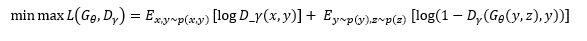

Ridge regularization, also known as L2 regularization, adds squared magnitude of coefficient as penalty term to the loss function. it can be written as follows:

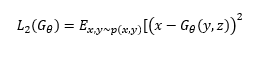

this regularization is meant to ensure the synthesised image will not deviate significantly from real image. Thus, with addition in optimization equation, we write this as follows:

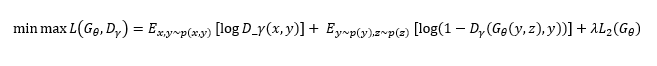

Then, we try to train this model again.

In [ ]:
optimizer_d = torch.optim.SGD(D.parameters(), lr=lr*0.4, weight_decay=1e-5)
optimizer_g = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.9), weight_decay=1e-5)

In [ ]:
tabel = pd.DataFrame(columns=['epoch','d_loss','g_loss_adversial','style_loss','content_loss','tv_loss'])
for epoch in range(max_epoch):
    for idx, (real_img, real_label,mask) in tqdm.tqdm(enumerate(trainloader)):
        # trainD
        make_trainable(D, True)
        make_trainable(G, False)

        D.zero_grad()
        optimizer_d.zero_grad()

        real_img = Variable(real_img).cuda()
        real_label = Variable(real_label.unsqueeze(1)).cuda()
        mask=Variable(mask.unsqueeze(1)).cuda()

        z = Variable(gen_rand_noise(batch_size,z_size)).cuda()
        real_label_mask_pair=torch.cat((real_label,mask),dim=1)
        fake_imgs=G(real_label_mask_pair,z)

        real_pair=torch.cat((real_img,real_label,mask),dim=1)
        fake_pair=torch.cat((fake_imgs,real_label,mask),dim=1)

        D_real_logits=D(real_pair)
        D_real_y=Variable(torch.ones((batch_size,1))).cuda()

        D_fake_logits=D(fake_pair)
        D_fake_y=Variable(torch.zeros((batch_size,1))).cuda()

        d_real_loss=bce(D_real_logits,D_real_y)
        d_fake_loss=bce(D_fake_logits,D_fake_y)

        d_loss=d_real_loss+d_fake_loss
        d_loss.backward()
        optimizer_d.step()

        #trainG twice
        make_trainable(G, True)
        make_trainable(D, False)
        make_trainable(Vgg,False)
        for _ in range(1):
            G.zero_grad()
            optimizer_g.zero_grad()

            z = Variable(gen_rand_noise(batch_size, z_size,0,0.5)).cuda()
            real_label_mask_pair = torch.cat((real_label, mask), dim=1)
            fake_imgs = G(real_label_mask_pair, z)
            fake_pair=torch.cat((fake_imgs,real_label,mask),dim=1)

            D_fake_logits=D(fake_pair)
            D_fake_y=Variable(torch.ones((batch_size,1))).cuda()
            #gan_loss
            g_loss_adversial=bce(D_fake_logits,D_fake_y)
            #style loss
            #style_loss=0.0
            #for i,style_img in enumerate(style_imgs):
            style_feature = get_style_features(Vgg, style_img,mask)
            style_loss=get_style_loss(style_feature,get_style_features(Vgg,fake_imgs,mask))#/len(style_imgs)
            #content_loss
            content_loss=get_content_loss(get_content_features(Vgg,real_img,mask),get_content_features(Vgg,fake_imgs,mask))
            #tv_loss
            tv_loss=get_tv_loss(fake_imgs)
            loss=L_gan_weight*g_loss_adversial+L_style_weight*style_loss+L_content_weight*content_loss+L_tv_weight*tv_loss
            loss.backward()
            optimizer_g.step()

    print("epoch[%d/%d] d_loss:%.4f g_loss_ad:%.4f style_loss:%.4f content_loss:%.4f tv_loss%.4f"%(
        epoch,max_epoch,d_loss,g_loss_adversial,style_loss,content_loss,tv_loss
    ))
    tabel.loc[epoch] = [int(epoch), round(float(d_loss), 4), round(float(g_loss_adversial), 4),
                        round(float(style_loss), 4), round(float(content_loss), 4), round(float(tv_loss), 4)]
    tabel.to_csv('tabel.csv', index = False)

    if epoch%50==0:
        G.eval()
        D.eval()

        os.mkdir('./pth/epoch%d'%epoch)
        for idx, (real_img, real_label, mask) in tqdm.tqdm(enumerate(valloader)):
            os.mkdir('./pth/epoch%d/label%d' %(epoch,idx) )
            real_img = Variable(real_img).cuda()
            real_label = Variable(real_label.unsqueeze(1)).cuda()
            img_label=real_label.squeeze(1).cpu().data[0].numpy()
            #print(img_label.shape)
            Image.fromarray(img_label.astype(np.uint8)).save('./pth/epoch%d/label%d/label.jpg'%(epoch,idx))
            mask = Variable(mask.unsqueeze(1)).cuda()

            for i in range(5):
                z=Variable(gen_rand_noise(1,z_size,0,0.5)).cuda()
                real_label_mask_pair = torch.cat((real_label, mask), dim=1)
                fake_imgs = G(real_label_mask_pair, z)[0].cpu().data.numpy()
                img=np.transpose(fake_imgs,[1,2,0])

                img=(img+1)*127.5
                img=Image.fromarray(img.astype(np.uint8))
                img.save('./pth/epoch%d/label%d/%d.jpg'%(epoch,idx,i))


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
20it [01:01,  3.05s/it]


epoch[0/200] d_loss:0.9867 g_loss_ad:0.3844 style_loss:8.3305 content_loss:27.7896 tv_loss0.1288


12it [00:25,  2.12s/it]
20it [00:21,  1.10s/it]


epoch[1/200] d_loss:0.0761 g_loss_ad:3.2389 style_loss:7.6214 content_loss:27.8215 tv_loss0.0745


20it [00:21,  1.09s/it]


epoch[2/200] d_loss:0.1011 g_loss_ad:2.8694 style_loss:4.9163 content_loss:25.1823 tv_loss0.0867


20it [00:21,  1.09s/it]


epoch[3/200] d_loss:0.6987 g_loss_ad:1.0818 style_loss:2.3527 content_loss:31.9050 tv_loss0.0693


20it [00:21,  1.09s/it]


epoch[4/200] d_loss:0.3212 g_loss_ad:1.9345 style_loss:2.3329 content_loss:26.0378 tv_loss0.0572


20it [00:21,  1.09s/it]


epoch[5/200] d_loss:0.3423 g_loss_ad:2.1132 style_loss:1.6773 content_loss:24.9275 tv_loss0.0552


20it [00:21,  1.09s/it]


epoch[6/200] d_loss:0.1264 g_loss_ad:2.8189 style_loss:3.5109 content_loss:27.0222 tv_loss0.0534


20it [00:21,  1.09s/it]


epoch[7/200] d_loss:0.1747 g_loss_ad:2.6304 style_loss:2.8441 content_loss:25.7056 tv_loss0.0501


20it [00:21,  1.09s/it]


epoch[8/200] d_loss:0.0573 g_loss_ad:3.5512 style_loss:1.6456 content_loss:27.4611 tv_loss0.0461


20it [00:21,  1.09s/it]


epoch[9/200] d_loss:0.0755 g_loss_ad:3.2002 style_loss:1.9298 content_loss:23.7069 tv_loss0.0455


20it [00:21,  1.09s/it]


epoch[10/200] d_loss:0.1812 g_loss_ad:2.5456 style_loss:1.3618 content_loss:22.2215 tv_loss0.0447


20it [00:21,  1.09s/it]


epoch[11/200] d_loss:0.0207 g_loss_ad:4.0877 style_loss:1.2605 content_loss:23.7888 tv_loss0.0433


20it [00:21,  1.09s/it]


epoch[12/200] d_loss:0.0549 g_loss_ad:3.5451 style_loss:2.7499 content_loss:24.2380 tv_loss0.0453


20it [00:21,  1.09s/it]


epoch[13/200] d_loss:0.0192 g_loss_ad:4.1731 style_loss:2.7767 content_loss:26.0367 tv_loss0.0443


20it [00:21,  1.09s/it]


epoch[14/200] d_loss:0.2261 g_loss_ad:2.2660 style_loss:1.3521 content_loss:22.9544 tv_loss0.0458


20it [00:21,  1.09s/it]


epoch[15/200] d_loss:0.1605 g_loss_ad:3.2113 style_loss:1.4213 content_loss:22.9146 tv_loss0.0465


20it [00:21,  1.09s/it]


epoch[16/200] d_loss:0.0777 g_loss_ad:3.4488 style_loss:1.1484 content_loss:23.2029 tv_loss0.0475


20it [00:21,  1.09s/it]


epoch[17/200] d_loss:0.0646 g_loss_ad:3.1640 style_loss:1.3951 content_loss:25.8085 tv_loss0.0450


20it [00:21,  1.09s/it]


epoch[18/200] d_loss:0.1126 g_loss_ad:3.0181 style_loss:2.1660 content_loss:22.9940 tv_loss0.0471


20it [00:21,  1.09s/it]


epoch[19/200] d_loss:0.1235 g_loss_ad:2.9907 style_loss:1.6905 content_loss:22.2293 tv_loss0.0435


20it [00:21,  1.09s/it]


epoch[20/200] d_loss:0.1316 g_loss_ad:3.1247 style_loss:3.1027 content_loss:26.8517 tv_loss0.0528


20it [00:21,  1.09s/it]


epoch[21/200] d_loss:0.2853 g_loss_ad:1.4992 style_loss:2.0467 content_loss:22.4451 tv_loss0.0452


20it [00:21,  1.09s/it]


epoch[22/200] d_loss:0.0289 g_loss_ad:4.1683 style_loss:1.4449 content_loss:26.0107 tv_loss0.0445


20it [00:21,  1.09s/it]


epoch[23/200] d_loss:0.0395 g_loss_ad:4.0500 style_loss:2.1559 content_loss:24.8281 tv_loss0.0466


20it [00:21,  1.09s/it]


epoch[24/200] d_loss:0.0706 g_loss_ad:2.8742 style_loss:1.2706 content_loss:24.0240 tv_loss0.0434


20it [00:21,  1.09s/it]


epoch[25/200] d_loss:0.1040 g_loss_ad:2.3619 style_loss:1.1304 content_loss:26.8959 tv_loss0.0464


20it [00:21,  1.09s/it]


epoch[26/200] d_loss:0.0208 g_loss_ad:2.9920 style_loss:0.9361 content_loss:27.0061 tv_loss0.0426


20it [00:21,  1.09s/it]


epoch[27/200] d_loss:1.5297 g_loss_ad:0.0001 style_loss:1.8631 content_loss:26.4857 tv_loss0.0437


20it [00:21,  1.09s/it]


epoch[28/200] d_loss:0.0614 g_loss_ad:2.4281 style_loss:1.2918 content_loss:23.7951 tv_loss0.0424


20it [00:21,  1.09s/it]


epoch[29/200] d_loss:0.0187 g_loss_ad:3.0789 style_loss:0.9125 content_loss:23.6315 tv_loss0.0401


20it [00:21,  1.09s/it]


epoch[30/200] d_loss:0.0184 g_loss_ad:3.2815 style_loss:0.8907 content_loss:22.5072 tv_loss0.0391


20it [00:21,  1.09s/it]


epoch[31/200] d_loss:0.0280 g_loss_ad:4.4490 style_loss:1.0074 content_loss:27.0826 tv_loss0.0403


20it [00:21,  1.09s/it]


epoch[32/200] d_loss:0.5773 g_loss_ad:3.7439 style_loss:1.9280 content_loss:24.4776 tv_loss0.0422


20it [00:21,  1.09s/it]


epoch[33/200] d_loss:0.0422 g_loss_ad:2.8174 style_loss:0.7627 content_loss:23.4255 tv_loss0.0410


20it [00:21,  1.09s/it]


epoch[34/200] d_loss:0.0174 g_loss_ad:3.3955 style_loss:0.8116 content_loss:25.9275 tv_loss0.0392


20it [00:21,  1.09s/it]


epoch[35/200] d_loss:0.0193 g_loss_ad:3.4580 style_loss:1.3353 content_loss:26.9515 tv_loss0.0405


20it [00:21,  1.09s/it]


epoch[36/200] d_loss:0.0120 g_loss_ad:3.6452 style_loss:1.0689 content_loss:30.8441 tv_loss0.0412


20it [00:21,  1.09s/it]


epoch[37/200] d_loss:0.0041 g_loss_ad:4.5729 style_loss:1.7614 content_loss:31.5848 tv_loss0.0417


20it [00:21,  1.09s/it]


epoch[38/200] d_loss:2.4763 g_loss_ad:6.8091 style_loss:0.9943 content_loss:22.6557 tv_loss0.0409


20it [00:21,  1.09s/it]


epoch[39/200] d_loss:0.2204 g_loss_ad:2.3722 style_loss:1.4025 content_loss:24.1264 tv_loss0.0414


20it [00:21,  1.09s/it]


epoch[40/200] d_loss:0.1843 g_loss_ad:2.5912 style_loss:1.6939 content_loss:22.7770 tv_loss0.0416


20it [00:21,  1.09s/it]


epoch[41/200] d_loss:0.0679 g_loss_ad:3.0390 style_loss:1.3698 content_loss:23.0851 tv_loss0.0423


20it [00:21,  1.09s/it]


epoch[42/200] d_loss:0.1086 g_loss_ad:2.9241 style_loss:1.8243 content_loss:26.8540 tv_loss0.0436


20it [00:21,  1.09s/it]


epoch[43/200] d_loss:0.0541 g_loss_ad:3.2929 style_loss:0.8654 content_loss:23.3510 tv_loss0.0412


20it [00:21,  1.09s/it]


epoch[44/200] d_loss:0.0873 g_loss_ad:2.8808 style_loss:1.1799 content_loss:26.4023 tv_loss0.0427


20it [00:21,  1.09s/it]


epoch[45/200] d_loss:0.1153 g_loss_ad:2.8375 style_loss:1.0495 content_loss:25.6678 tv_loss0.0427


20it [00:21,  1.09s/it]


epoch[46/200] d_loss:0.0957 g_loss_ad:2.5432 style_loss:0.8843 content_loss:24.4388 tv_loss0.0433


20it [00:21,  1.09s/it]


epoch[47/200] d_loss:0.8884 g_loss_ad:4.3787 style_loss:0.6519 content_loss:23.7191 tv_loss0.0422


20it [00:21,  1.09s/it]


epoch[48/200] d_loss:0.0182 g_loss_ad:4.4564 style_loss:0.8000 content_loss:26.0958 tv_loss0.0420


20it [00:21,  1.09s/it]


epoch[49/200] d_loss:0.0824 g_loss_ad:2.7838 style_loss:0.9874 content_loss:25.9489 tv_loss0.0409


20it [00:21,  1.09s/it]


epoch[50/200] d_loss:0.0215 g_loss_ad:2.8555 style_loss:0.8788 content_loss:24.4218 tv_loss0.0419


12it [00:05,  2.40it/s]
20it [00:21,  1.09s/it]


epoch[51/200] d_loss:0.2117 g_loss_ad:2.8650 style_loss:0.8502 content_loss:25.4609 tv_loss0.0389


20it [00:21,  1.09s/it]


epoch[52/200] d_loss:0.0595 g_loss_ad:6.2222 style_loss:0.7760 content_loss:25.5268 tv_loss0.0415


20it [00:21,  1.09s/it]


epoch[53/200] d_loss:1.3634 g_loss_ad:0.1459 style_loss:0.5988 content_loss:23.3233 tv_loss0.0411


20it [00:21,  1.09s/it]


epoch[54/200] d_loss:0.0636 g_loss_ad:2.6250 style_loss:1.0022 content_loss:25.6401 tv_loss0.0426


20it [00:21,  1.09s/it]


epoch[55/200] d_loss:0.4276 g_loss_ad:2.7697 style_loss:0.8219 content_loss:22.3288 tv_loss0.0400


20it [00:21,  1.09s/it]


epoch[56/200] d_loss:0.0175 g_loss_ad:5.4773 style_loss:0.9489 content_loss:26.4703 tv_loss0.0427


20it [00:21,  1.09s/it]


epoch[57/200] d_loss:2.0768 g_loss_ad:8.7160 style_loss:0.8442 content_loss:25.5358 tv_loss0.0406


20it [00:21,  1.09s/it]


epoch[58/200] d_loss:0.8510 g_loss_ad:3.1817 style_loss:0.7010 content_loss:21.9142 tv_loss0.0416


20it [00:21,  1.09s/it]


epoch[59/200] d_loss:0.0055 g_loss_ad:4.5496 style_loss:0.4949 content_loss:24.8256 tv_loss0.0405


20it [00:21,  1.09s/it]


epoch[60/200] d_loss:0.0309 g_loss_ad:2.7592 style_loss:0.8215 content_loss:23.5757 tv_loss0.0399


20it [00:21,  1.09s/it]


epoch[61/200] d_loss:0.4225 g_loss_ad:0.3995 style_loss:1.2411 content_loss:22.2699 tv_loss0.0418


20it [00:21,  1.09s/it]


epoch[62/200] d_loss:0.0162 g_loss_ad:3.2283 style_loss:0.6760 content_loss:24.0607 tv_loss0.0407


20it [00:21,  1.09s/it]


epoch[63/200] d_loss:0.1320 g_loss_ad:1.9293 style_loss:0.6034 content_loss:22.1107 tv_loss0.0393


20it [00:21,  1.09s/it]


epoch[64/200] d_loss:0.0450 g_loss_ad:2.2800 style_loss:1.3271 content_loss:26.8079 tv_loss0.0392


20it [00:21,  1.09s/it]


epoch[65/200] d_loss:3.6782 g_loss_ad:5.1754 style_loss:0.6921 content_loss:21.6933 tv_loss0.0393


20it [00:21,  1.09s/it]


epoch[66/200] d_loss:0.3734 g_loss_ad:0.4746 style_loss:0.6745 content_loss:23.3989 tv_loss0.0403


20it [00:21,  1.10s/it]


epoch[67/200] d_loss:1.6884 g_loss_ad:0.0045 style_loss:1.6074 content_loss:23.1310 tv_loss0.0413


20it [00:21,  1.09s/it]


epoch[68/200] d_loss:0.0283 g_loss_ad:4.7873 style_loss:0.7622 content_loss:24.1643 tv_loss0.0387


20it [00:21,  1.09s/it]


epoch[69/200] d_loss:0.0315 g_loss_ad:7.5869 style_loss:1.6601 content_loss:25.6377 tv_loss0.0393


20it [00:21,  1.09s/it]


epoch[70/200] d_loss:0.0156 g_loss_ad:8.3834 style_loss:0.6100 content_loss:25.9322 tv_loss0.0397


20it [00:21,  1.09s/it]


epoch[71/200] d_loss:0.0170 g_loss_ad:3.7713 style_loss:0.9214 content_loss:23.5564 tv_loss0.0393


20it [00:21,  1.09s/it]


epoch[72/200] d_loss:0.0064 g_loss_ad:4.1553 style_loss:0.6832 content_loss:24.7148 tv_loss0.0397


20it [00:21,  1.09s/it]


epoch[73/200] d_loss:0.0400 g_loss_ad:2.4133 style_loss:0.7402 content_loss:24.7515 tv_loss0.0398


20it [00:21,  1.09s/it]


epoch[74/200] d_loss:0.0263 g_loss_ad:3.2460 style_loss:0.7592 content_loss:22.9016 tv_loss0.0384


20it [00:21,  1.09s/it]


epoch[75/200] d_loss:0.0199 g_loss_ad:3.2753 style_loss:0.7390 content_loss:26.9427 tv_loss0.0400


20it [00:21,  1.09s/it]


epoch[76/200] d_loss:0.1422 g_loss_ad:1.7791 style_loss:0.6561 content_loss:21.9882 tv_loss0.0385


20it [00:21,  1.09s/it]


epoch[77/200] d_loss:0.0284 g_loss_ad:2.9800 style_loss:0.6232 content_loss:24.9367 tv_loss0.0391


20it [00:21,  1.09s/it]


epoch[78/200] d_loss:0.0024 g_loss_ad:6.4078 style_loss:0.8557 content_loss:25.1014 tv_loss0.0388


20it [00:21,  1.09s/it]


epoch[79/200] d_loss:0.0363 g_loss_ad:3.1779 style_loss:0.8658 content_loss:23.8304 tv_loss0.0404


20it [00:21,  1.09s/it]


epoch[80/200] d_loss:0.0068 g_loss_ad:4.3409 style_loss:0.5260 content_loss:24.8746 tv_loss0.0400


20it [00:21,  1.09s/it]


epoch[81/200] d_loss:0.1868 g_loss_ad:1.9927 style_loss:0.8238 content_loss:26.3252 tv_loss0.0396


20it [00:21,  1.09s/it]


epoch[82/200] d_loss:0.1781 g_loss_ad:2.6586 style_loss:0.7524 content_loss:23.3026 tv_loss0.0392


20it [00:21,  1.09s/it]


epoch[83/200] d_loss:0.0877 g_loss_ad:3.9986 style_loss:0.6969 content_loss:23.1519 tv_loss0.0388


20it [00:21,  1.09s/it]


epoch[84/200] d_loss:0.0374 g_loss_ad:4.7246 style_loss:0.7342 content_loss:23.2773 tv_loss0.0397


20it [00:21,  1.09s/it]


epoch[85/200] d_loss:0.0116 g_loss_ad:3.0718 style_loss:1.0217 content_loss:27.0931 tv_loss0.0410


20it [00:21,  1.09s/it]


epoch[86/200] d_loss:0.0003 g_loss_ad:6.7040 style_loss:1.0543 content_loss:30.3091 tv_loss0.0391


20it [00:21,  1.09s/it]


epoch[87/200] d_loss:0.0282 g_loss_ad:3.1475 style_loss:0.6218 content_loss:23.4446 tv_loss0.0392


20it [00:21,  1.09s/it]


epoch[88/200] d_loss:0.0087 g_loss_ad:3.4564 style_loss:0.8679 content_loss:25.5204 tv_loss0.0403


20it [00:21,  1.09s/it]


epoch[89/200] d_loss:0.0140 g_loss_ad:2.9993 style_loss:0.8624 content_loss:30.4545 tv_loss0.0410


20it [00:21,  1.09s/it]


epoch[90/200] d_loss:0.0128 g_loss_ad:5.3118 style_loss:0.8992 content_loss:24.5482 tv_loss0.0395


20it [00:21,  1.09s/it]


epoch[91/200] d_loss:0.3525 g_loss_ad:5.8989 style_loss:0.7799 content_loss:25.9294 tv_loss0.0404


20it [00:21,  1.09s/it]


epoch[92/200] d_loss:0.2150 g_loss_ad:3.6884 style_loss:0.6748 content_loss:25.5717 tv_loss0.0396


20it [00:21,  1.09s/it]


epoch[93/200] d_loss:2.4201 g_loss_ad:0.0002 style_loss:1.3110 content_loss:22.7082 tv_loss0.0405


20it [00:21,  1.09s/it]


epoch[94/200] d_loss:0.1351 g_loss_ad:1.9199 style_loss:1.0654 content_loss:24.9892 tv_loss0.0403


20it [00:21,  1.09s/it]


epoch[95/200] d_loss:0.5184 g_loss_ad:0.3460 style_loss:1.0558 content_loss:22.0225 tv_loss0.0391


20it [00:21,  1.09s/it]


epoch[96/200] d_loss:0.2863 g_loss_ad:3.9765 style_loss:1.0207 content_loss:22.9993 tv_loss0.0385


20it [00:21,  1.09s/it]


epoch[97/200] d_loss:0.1587 g_loss_ad:3.4374 style_loss:0.6469 content_loss:23.7420 tv_loss0.0394


20it [00:21,  1.09s/it]


epoch[98/200] d_loss:0.0242 g_loss_ad:3.6100 style_loss:0.9812 content_loss:24.8902 tv_loss0.0384


20it [00:21,  1.09s/it]


epoch[99/200] d_loss:0.0064 g_loss_ad:4.0189 style_loss:0.7988 content_loss:30.5035 tv_loss0.0384


20it [00:21,  1.09s/it]


epoch[100/200] d_loss:0.0086 g_loss_ad:4.3621 style_loss:0.9735 content_loss:25.3019 tv_loss0.0397


12it [00:04,  2.42it/s]
20it [00:21,  1.09s/it]


epoch[101/200] d_loss:0.2062 g_loss_ad:2.6033 style_loss:0.8373 content_loss:22.1371 tv_loss0.0375


20it [00:21,  1.09s/it]


epoch[102/200] d_loss:0.0012 g_loss_ad:6.5518 style_loss:1.0683 content_loss:26.8829 tv_loss0.0394


20it [00:21,  1.09s/it]


epoch[103/200] d_loss:0.0187 g_loss_ad:3.7338 style_loss:0.8166 content_loss:25.3853 tv_loss0.0385


20it [00:21,  1.09s/it]


epoch[104/200] d_loss:0.0690 g_loss_ad:2.5286 style_loss:1.0618 content_loss:25.7686 tv_loss0.0394


20it [00:21,  1.09s/it]


epoch[105/200] d_loss:0.0726 g_loss_ad:2.8166 style_loss:0.6940 content_loss:26.1698 tv_loss0.0405


20it [00:21,  1.09s/it]


epoch[106/200] d_loss:0.0946 g_loss_ad:2.3985 style_loss:0.7915 content_loss:23.2289 tv_loss0.0387


20it [00:21,  1.09s/it]


epoch[107/200] d_loss:0.0163 g_loss_ad:4.9305 style_loss:0.8288 content_loss:23.7971 tv_loss0.0379


20it [00:21,  1.09s/it]


epoch[108/200] d_loss:0.1103 g_loss_ad:2.3708 style_loss:1.7477 content_loss:23.3073 tv_loss0.0398


20it [00:21,  1.09s/it]


epoch[109/200] d_loss:0.4028 g_loss_ad:3.9295 style_loss:0.7729 content_loss:24.6734 tv_loss0.0384


20it [00:21,  1.09s/it]


epoch[110/200] d_loss:0.1057 g_loss_ad:2.3923 style_loss:0.7380 content_loss:24.5824 tv_loss0.0368


20it [00:21,  1.09s/it]


epoch[111/200] d_loss:0.1919 g_loss_ad:1.6509 style_loss:0.7554 content_loss:23.2102 tv_loss0.0375


20it [00:21,  1.09s/it]


epoch[112/200] d_loss:0.0267 g_loss_ad:5.3089 style_loss:0.6485 content_loss:24.7809 tv_loss0.0377


20it [00:21,  1.09s/it]


epoch[113/200] d_loss:0.1510 g_loss_ad:3.0727 style_loss:0.9929 content_loss:21.7729 tv_loss0.0366


20it [00:21,  1.09s/it]


epoch[114/200] d_loss:0.0139 g_loss_ad:4.7872 style_loss:0.7840 content_loss:23.3271 tv_loss0.0398


20it [00:21,  1.09s/it]


epoch[115/200] d_loss:0.0254 g_loss_ad:5.0498 style_loss:1.0142 content_loss:25.9804 tv_loss0.0400


20it [00:21,  1.09s/it]


epoch[116/200] d_loss:1.2007 g_loss_ad:10.1782 style_loss:0.6783 content_loss:23.3130 tv_loss0.0369


20it [00:21,  1.09s/it]


epoch[117/200] d_loss:0.0432 g_loss_ad:3.1038 style_loss:1.2272 content_loss:25.1990 tv_loss0.0374


20it [00:21,  1.09s/it]


epoch[118/200] d_loss:0.0019 g_loss_ad:6.5796 style_loss:0.6880 content_loss:23.8794 tv_loss0.0360


20it [00:21,  1.09s/it]


epoch[119/200] d_loss:0.7766 g_loss_ad:9.2962 style_loss:0.8405 content_loss:23.8081 tv_loss0.0382


20it [00:21,  1.09s/it]


epoch[120/200] d_loss:0.0200 g_loss_ad:3.3718 style_loss:1.4914 content_loss:30.4607 tv_loss0.0372


20it [00:21,  1.09s/it]


epoch[121/200] d_loss:0.0367 g_loss_ad:8.5397 style_loss:0.7922 content_loss:25.9253 tv_loss0.0383


20it [00:21,  1.09s/it]


epoch[122/200] d_loss:0.0419 g_loss_ad:3.0336 style_loss:0.7841 content_loss:23.6593 tv_loss0.0404


20it [00:21,  1.09s/it]


epoch[123/200] d_loss:0.0032 g_loss_ad:5.1621 style_loss:0.9654 content_loss:30.6424 tv_loss0.0387


20it [00:21,  1.09s/it]


epoch[124/200] d_loss:0.5590 g_loss_ad:0.7165 style_loss:1.6913 content_loss:23.7269 tv_loss0.0381


20it [00:21,  1.09s/it]


epoch[125/200] d_loss:1.1990 g_loss_ad:0.0226 style_loss:0.7817 content_loss:22.5602 tv_loss0.0391


20it [00:21,  1.09s/it]


epoch[126/200] d_loss:0.0442 g_loss_ad:4.5931 style_loss:0.9890 content_loss:24.4226 tv_loss0.0390


20it [00:21,  1.09s/it]


epoch[127/200] d_loss:3.3195 g_loss_ad:0.0000 style_loss:0.7196 content_loss:23.9901 tv_loss0.0398


20it [00:21,  1.09s/it]


epoch[128/200] d_loss:0.1757 g_loss_ad:3.3552 style_loss:0.9005 content_loss:24.6546 tv_loss0.0385


20it [00:21,  1.09s/it]


epoch[129/200] d_loss:0.0005 g_loss_ad:7.6132 style_loss:0.9640 content_loss:29.4245 tv_loss0.0367


20it [00:21,  1.09s/it]


epoch[130/200] d_loss:0.6227 g_loss_ad:0.1152 style_loss:1.8462 content_loss:25.5324 tv_loss0.0407


20it [00:21,  1.09s/it]


epoch[131/200] d_loss:0.2514 g_loss_ad:3.3433 style_loss:0.8870 content_loss:24.3280 tv_loss0.0393


20it [00:21,  1.09s/it]


epoch[132/200] d_loss:0.0278 g_loss_ad:10.8638 style_loss:0.7681 content_loss:26.3913 tv_loss0.0385


20it [00:21,  1.09s/it]


epoch[133/200] d_loss:0.0199 g_loss_ad:3.9596 style_loss:0.5930 content_loss:23.4918 tv_loss0.0404


20it [00:21,  1.09s/it]


epoch[134/200] d_loss:0.0520 g_loss_ad:3.5513 style_loss:1.5196 content_loss:25.3762 tv_loss0.0393


20it [00:21,  1.09s/it]


epoch[135/200] d_loss:0.0428 g_loss_ad:2.9677 style_loss:0.5632 content_loss:23.9622 tv_loss0.0376


20it [00:21,  1.09s/it]


epoch[136/200] d_loss:0.1248 g_loss_ad:3.1001 style_loss:0.6505 content_loss:22.4956 tv_loss0.0377


20it [00:21,  1.09s/it]


epoch[137/200] d_loss:0.0088 g_loss_ad:4.0323 style_loss:0.4806 content_loss:24.4742 tv_loss0.0385


20it [00:21,  1.09s/it]


epoch[138/200] d_loss:0.0896 g_loss_ad:2.4191 style_loss:1.0650 content_loss:25.5538 tv_loss0.0381


20it [00:21,  1.09s/it]


epoch[139/200] d_loss:0.0615 g_loss_ad:5.3041 style_loss:0.8632 content_loss:26.9390 tv_loss0.0409


20it [00:21,  1.09s/it]


epoch[140/200] d_loss:0.0497 g_loss_ad:3.1847 style_loss:0.8117 content_loss:23.1726 tv_loss0.0388


20it [00:21,  1.09s/it]


epoch[141/200] d_loss:0.0436 g_loss_ad:3.0362 style_loss:0.6418 content_loss:22.8153 tv_loss0.0386


20it [00:21,  1.09s/it]


epoch[142/200] d_loss:0.0166 g_loss_ad:4.5112 style_loss:0.9565 content_loss:25.2089 tv_loss0.0391


20it [00:21,  1.09s/it]


epoch[143/200] d_loss:0.0131 g_loss_ad:4.1890 style_loss:0.7554 content_loss:23.6623 tv_loss0.0385


20it [00:21,  1.09s/it]


epoch[144/200] d_loss:0.7649 g_loss_ad:7.9155 style_loss:1.0202 content_loss:26.1545 tv_loss0.0371


20it [00:21,  1.09s/it]


epoch[145/200] d_loss:0.0184 g_loss_ad:3.9767 style_loss:0.7867 content_loss:22.4759 tv_loss0.0384


20it [00:21,  1.09s/it]


epoch[146/200] d_loss:0.1517 g_loss_ad:3.0696 style_loss:0.7891 content_loss:21.6390 tv_loss0.0377


20it [00:21,  1.09s/it]


epoch[147/200] d_loss:0.0099 g_loss_ad:4.7555 style_loss:1.4047 content_loss:26.1385 tv_loss0.0400


20it [00:21,  1.09s/it]


epoch[148/200] d_loss:0.0052 g_loss_ad:5.4678 style_loss:0.5497 content_loss:25.8086 tv_loss0.0386


20it [00:21,  1.09s/it]


epoch[149/200] d_loss:0.0281 g_loss_ad:5.7945 style_loss:0.8537 content_loss:23.5312 tv_loss0.0400


20it [00:21,  1.09s/it]


epoch[150/200] d_loss:0.0145 g_loss_ad:4.3294 style_loss:0.6818 content_loss:24.6828 tv_loss0.0457


12it [00:05,  2.36it/s]
20it [00:21,  1.09s/it]


epoch[151/200] d_loss:0.0278 g_loss_ad:12.6775 style_loss:0.4734 content_loss:26.8314 tv_loss0.0495


20it [00:21,  1.09s/it]


epoch[152/200] d_loss:0.0127 g_loss_ad:6.2214 style_loss:1.1844 content_loss:25.7900 tv_loss0.0512


20it [00:21,  1.09s/it]


epoch[153/200] d_loss:0.0668 g_loss_ad:3.2996 style_loss:0.8162 content_loss:22.2836 tv_loss0.0440


20it [00:21,  1.09s/it]


epoch[154/200] d_loss:0.3912 g_loss_ad:5.5184 style_loss:0.7442 content_loss:21.8334 tv_loss0.0502


20it [00:21,  1.09s/it]


epoch[155/200] d_loss:0.0177 g_loss_ad:5.1854 style_loss:0.6751 content_loss:22.9162 tv_loss0.0497


20it [00:21,  1.09s/it]


epoch[156/200] d_loss:0.0029 g_loss_ad:5.3405 style_loss:1.1628 content_loss:25.1466 tv_loss0.0487


20it [00:21,  1.09s/it]


epoch[157/200] d_loss:0.2349 g_loss_ad:3.8989 style_loss:0.9440 content_loss:26.2967 tv_loss0.0404


20it [00:21,  1.09s/it]


epoch[158/200] d_loss:0.1179 g_loss_ad:3.5048 style_loss:1.4337 content_loss:23.5419 tv_loss0.0441


20it [00:21,  1.09s/it]


epoch[159/200] d_loss:0.0566 g_loss_ad:3.3242 style_loss:0.6510 content_loss:27.2981 tv_loss0.0500


20it [00:21,  1.09s/it]


epoch[160/200] d_loss:0.0069 g_loss_ad:6.0892 style_loss:0.8977 content_loss:25.2194 tv_loss0.0495


20it [00:21,  1.09s/it]


epoch[161/200] d_loss:0.0150 g_loss_ad:6.7934 style_loss:0.8531 content_loss:25.2655 tv_loss0.0443


20it [00:21,  1.09s/it]


epoch[162/200] d_loss:0.3480 g_loss_ad:5.5654 style_loss:1.0758 content_loss:21.0742 tv_loss0.0435


20it [00:21,  1.09s/it]


epoch[163/200] d_loss:0.4625 g_loss_ad:6.6633 style_loss:0.8967 content_loss:21.6673 tv_loss0.0464


20it [00:21,  1.09s/it]


epoch[164/200] d_loss:0.0146 g_loss_ad:7.4106 style_loss:0.8487 content_loss:25.1909 tv_loss0.0491


20it [00:21,  1.09s/it]


epoch[165/200] d_loss:0.6056 g_loss_ad:4.2793 style_loss:0.8726 content_loss:23.3282 tv_loss0.0412


20it [00:21,  1.09s/it]


epoch[166/200] d_loss:0.0157 g_loss_ad:4.1277 style_loss:0.8587 content_loss:24.0683 tv_loss0.0506


20it [00:21,  1.09s/it]


epoch[167/200] d_loss:0.3189 g_loss_ad:4.9882 style_loss:0.9202 content_loss:22.8149 tv_loss0.0500


20it [00:21,  1.09s/it]


epoch[168/200] d_loss:0.3168 g_loss_ad:4.5096 style_loss:0.7491 content_loss:26.0003 tv_loss0.0489


20it [00:21,  1.09s/it]


epoch[169/200] d_loss:0.3593 g_loss_ad:2.0051 style_loss:0.7264 content_loss:21.9309 tv_loss0.0515


20it [00:21,  1.09s/it]


epoch[170/200] d_loss:0.5807 g_loss_ad:3.6612 style_loss:1.3868 content_loss:22.8522 tv_loss0.0465


20it [00:21,  1.09s/it]


epoch[171/200] d_loss:0.0006 g_loss_ad:8.1114 style_loss:1.0191 content_loss:31.4181 tv_loss0.0474


20it [00:21,  1.09s/it]


epoch[172/200] d_loss:0.3935 g_loss_ad:1.5833 style_loss:0.5822 content_loss:26.4911 tv_loss0.0485


20it [00:21,  1.09s/it]


epoch[173/200] d_loss:0.0051 g_loss_ad:6.0070 style_loss:0.8976 content_loss:24.6598 tv_loss0.0472


20it [00:21,  1.09s/it]


epoch[174/200] d_loss:0.1746 g_loss_ad:3.5850 style_loss:0.7778 content_loss:22.1057 tv_loss0.0479


20it [00:21,  1.09s/it]


epoch[175/200] d_loss:0.0170 g_loss_ad:4.7501 style_loss:0.7301 content_loss:24.1233 tv_loss0.0469


20it [00:21,  1.09s/it]


epoch[176/200] d_loss:0.0719 g_loss_ad:10.5855 style_loss:1.3491 content_loss:26.3254 tv_loss0.0488


20it [00:21,  1.09s/it]


epoch[177/200] d_loss:0.0656 g_loss_ad:3.7946 style_loss:0.7005 content_loss:23.3383 tv_loss0.0504


20it [00:21,  1.09s/it]


epoch[178/200] d_loss:0.0312 g_loss_ad:4.2227 style_loss:0.9777 content_loss:26.0992 tv_loss0.0458


20it [00:21,  1.09s/it]


epoch[179/200] d_loss:0.4110 g_loss_ad:1.6307 style_loss:0.7861 content_loss:21.6608 tv_loss0.0557


20it [00:21,  1.09s/it]


epoch[180/200] d_loss:0.0170 g_loss_ad:4.4335 style_loss:0.6422 content_loss:25.2779 tv_loss0.0505


20it [00:21,  1.09s/it]


epoch[181/200] d_loss:0.0034 g_loss_ad:6.9126 style_loss:0.6335 content_loss:23.4956 tv_loss0.0440


20it [00:21,  1.09s/it]


epoch[182/200] d_loss:0.0454 g_loss_ad:3.7753 style_loss:0.9118 content_loss:23.2223 tv_loss0.0429


20it [00:21,  1.09s/it]


epoch[183/200] d_loss:0.3924 g_loss_ad:5.4592 style_loss:0.7980 content_loss:21.3487 tv_loss0.0478


20it [00:21,  1.09s/it]


epoch[184/200] d_loss:0.0723 g_loss_ad:3.6594 style_loss:1.4098 content_loss:22.1562 tv_loss0.0448


20it [00:21,  1.09s/it]


epoch[185/200] d_loss:0.0320 g_loss_ad:3.3279 style_loss:0.7032 content_loss:26.5274 tv_loss0.0432


20it [00:21,  1.09s/it]


epoch[186/200] d_loss:0.6505 g_loss_ad:0.1426 style_loss:0.8324 content_loss:22.4968 tv_loss0.0485


20it [00:21,  1.09s/it]


epoch[187/200] d_loss:0.0960 g_loss_ad:4.6956 style_loss:0.6534 content_loss:24.8846 tv_loss0.0457


20it [00:21,  1.09s/it]


epoch[188/200] d_loss:0.0109 g_loss_ad:4.6379 style_loss:0.7877 content_loss:24.8015 tv_loss0.0478


20it [00:21,  1.09s/it]


epoch[189/200] d_loss:0.0318 g_loss_ad:3.6526 style_loss:1.0544 content_loss:26.6992 tv_loss0.0467


20it [00:21,  1.09s/it]


epoch[190/200] d_loss:0.0328 g_loss_ad:3.9042 style_loss:0.9085 content_loss:23.3445 tv_loss0.0464


20it [00:21,  1.09s/it]


epoch[191/200] d_loss:0.2248 g_loss_ad:2.2882 style_loss:0.8460 content_loss:22.6444 tv_loss0.0488


20it [00:21,  1.09s/it]


epoch[192/200] d_loss:0.0955 g_loss_ad:3.1159 style_loss:0.8262 content_loss:24.4740 tv_loss0.0476


20it [00:21,  1.09s/it]


epoch[193/200] d_loss:0.0295 g_loss_ad:7.0731 style_loss:0.5867 content_loss:30.2399 tv_loss0.0479


20it [00:21,  1.09s/it]


epoch[194/200] d_loss:0.0442 g_loss_ad:7.7140 style_loss:1.0585 content_loss:26.6695 tv_loss0.0453


20it [00:21,  1.09s/it]


epoch[195/200] d_loss:0.0073 g_loss_ad:5.1159 style_loss:0.7162 content_loss:24.8178 tv_loss0.0446


20it [00:21,  1.09s/it]


epoch[196/200] d_loss:0.1615 g_loss_ad:2.9190 style_loss:0.9323 content_loss:22.0364 tv_loss0.0441


20it [00:21,  1.09s/it]


epoch[197/200] d_loss:0.1820 g_loss_ad:3.0180 style_loss:1.1610 content_loss:22.9576 tv_loss0.0415


20it [00:21,  1.09s/it]


epoch[198/200] d_loss:0.1084 g_loss_ad:4.0081 style_loss:0.8109 content_loss:23.0396 tv_loss0.0454


20it [00:21,  1.09s/it]


epoch[199/200] d_loss:0.1742 g_loss_ad:3.1266 style_loss:0.8835 content_loss:22.3867 tv_loss0.0479


# models history

In [ ]:
import pandas as pd
tabel_L2 = pd.read_csv('/content/drive/MyDrive/Fila-sGAN-pytorch/tabel.csv')
tabel = pd.read_csv('/content/drive/MyDrive/Fila-sGAN-pytorch/pth_1/tabel.csv')

In [ ]:
tabel.describe()

,epoch,d_loss,g_loss_adversial,style_loss,content_loss,tv_loss
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,191.500000,0.834979,4.298578,1.095558,23.743486,0.039475
std,110.995495,7.240073,2.266149,0.627779,2.440268,0.006921
min,0.000000,0.000000,0.000000,0.466300,16.773900,0.034400
25%,95.750000,0.015875,3.077600,0.794025,22.135350,0.037175
50%,191.500000,0.042300,4.067650,0.982850,23.407700,0.038300
75%,287.250000,0.187750,5.435025,1.224825,25.048800,0.040100
max,383.000000,100.000000,13.631900,7.763100,32.394300,0.148500


In [ ]:
tabel_L2.describe()

,epoch,d_loss,g_loss_adversial,style_loss,content_loss,tv_loss
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,99.500000,0.234430,3.881504,1.131061,24.736773,0.043398
std,57.879185,0.501943,2.059529,0.887100,2.128367,0.008556
min,0.000000,0.000300,0.000000,0.473400,21.074200,0.036000
25%,49.750000,0.019275,2.832850,0.755400,23.219275,0.039200
50%,99.500000,0.064100,3.457200,0.883900,24.512900,0.041000
75%,149.250000,0.188075,4.702850,1.181025,25.936375,0.045700
max,199.000000,3.678200,12.677500,8.330500,31.905000,0.128800


The style loss is used to minimize the textural
deviation between the target style $x_s$ and the phantom $x$ hat.

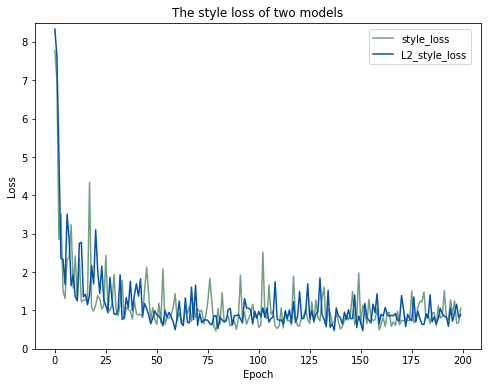

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.plot(tabel.epoch.iloc[:200], tabel.style_loss.iloc[:200], '-', color='#759e80', label='style_loss')
plt.plot(tabel_L2.epoch, tabel_L2.style_loss, '-', color='#0352ab', label='L2_style_loss')
plt.legend(bbox_to_anchor=(0.75, 0.98), loc='upper left', borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.title('The style loss of two models')
plt.ylim((0,8.5))
#axes = plt.axes()
#axes.set_ylim([1000000000000,7500000000000])
plt.show()

The discriminant loss

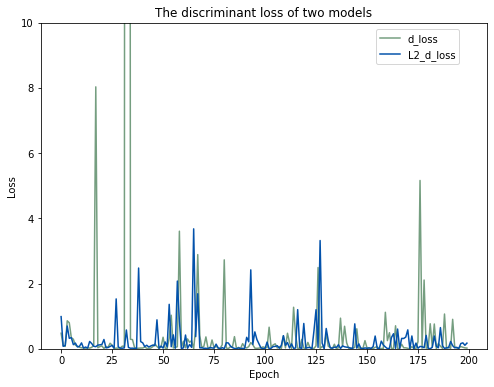

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(tabel.epoch.iloc[:200], tabel.d_loss.iloc[:200], '-', color='#759e80', label='d_loss')
plt.plot(tabel_L2.epoch, tabel_L2.d_loss, '-', color='#0352ab', label='L2_d_loss')
#plt.plot(tabel.epoch, tabel.tv_loss, '-', color='#759e80', label='tv_loss')
plt.legend(bbox_to_anchor=(0.75, 0.98), loc='upper left', borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.title('The discriminant loss of two models')
plt.ylim((0,10))
#axes = plt.axes()
#axes.set_ylim([1000000000000,7500000000000])
plt.show()

The content loss 

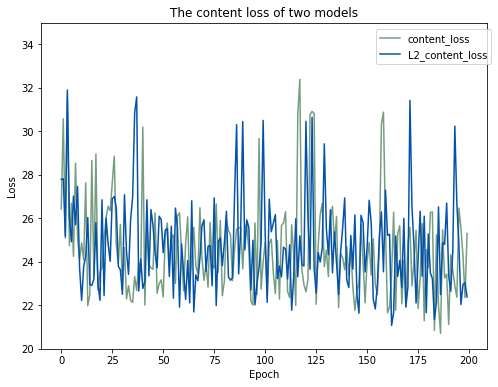

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(tabel.epoch.iloc[:200], tabel.content_loss.iloc[:200], '-', color='#759e80', label='content_loss')
plt.plot(tabel_L2.epoch, tabel_L2.content_loss, '-', color='#0352ab', label='L2_content_loss')
#plt.plot(tabel.epoch, tabel.tv_loss, '-', color='#759e80', label='tv_loss')
plt.legend(bbox_to_anchor=(0.75, 0.98), loc='upper left', borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.title('The content loss of two models')
plt.ylim((20,35))
#axes = plt.axes()
#axes.set_ylim([1000000000000,7500000000000])
plt.show()

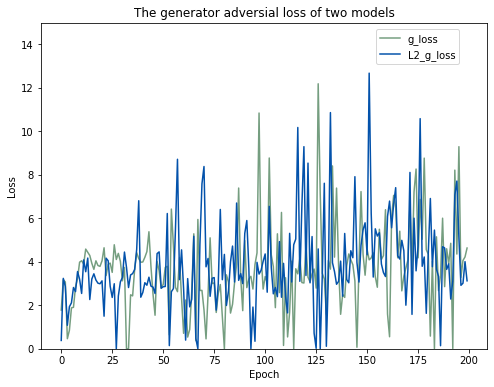

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(tabel.epoch.iloc[:200], tabel.g_loss_adversial.iloc[:200], '-', color='#759e80', label='g_loss')
plt.plot(tabel_L2.epoch, tabel_L2.g_loss_adversial, '-', color='#0352ab', label='L2_g_loss')
#plt.plot(tabel.epoch, tabel.tv_loss, '-', color='#759e80', label='tv_loss')
plt.legend(bbox_to_anchor=(0.75, 0.98), loc='upper left', borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.title('The generator adversial loss of two models')
plt.ylim((0,15))
#axes = plt.axes()
#axes.set_ylim([1000000000000,7500000000000])
plt.show()

# Total variant loss
it is the spatial smoothness in generated phantom of losses

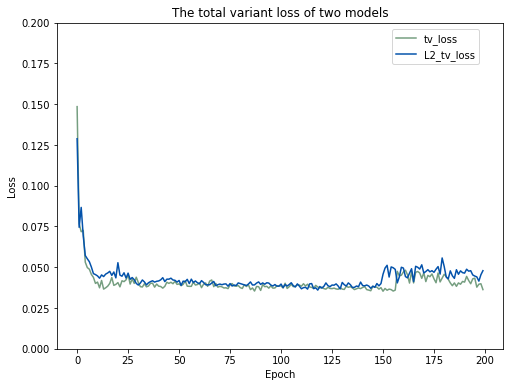

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(tabel.epoch.iloc[:200], tabel.tv_loss.iloc[:200], '-', color='#759e80', label='tv_loss')
plt.plot(tabel_L2.epoch, tabel_L2.tv_loss, '-', color='#0352ab', label='L2_tv_loss')
#plt.plot(tabel.epoch, tabel.tv_loss, '-', color='#759e80', label='tv_loss')
plt.legend(bbox_to_anchor=(0.75, 0.98), loc='upper left', borderaxespad=0.)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.title('The total variant loss of two models')
plt.ylim((0,0.2))
#axes = plt.axes()
#axes.set_ylim([1000000000000,7500000000000])
plt.show()

#GAN image

the image generated by GAN can be seen at https://drive.google.com/drive/folders/1oO116msDEyFJ_irHGv-9zJfMkdratsDT?usp=sharing (restricted email@sci.ui.ac.id only, you can request anyway).

This is one of the generated image.

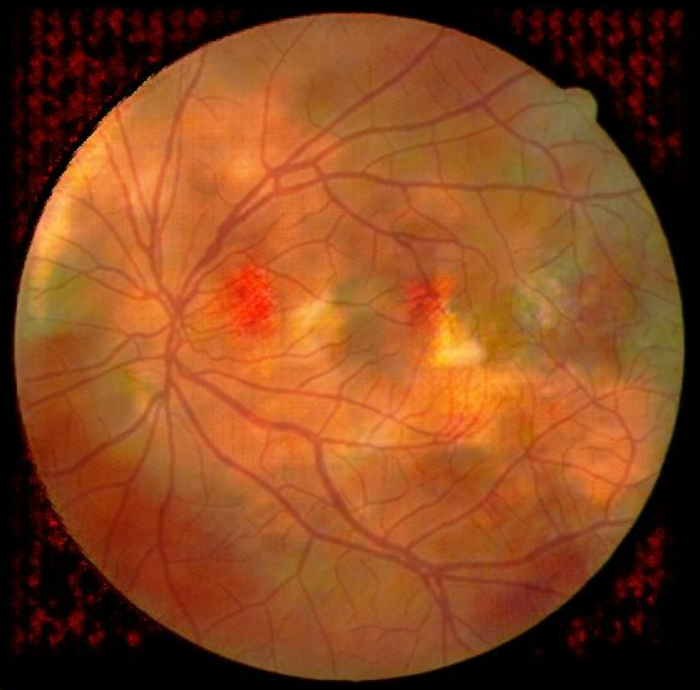